In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
from scipy import stats

In [22]:
QVI_data = pd.read_csv("C:/Users/agast/OneDrive/Documents/Power BI Project/QVI_data.csv")

In [23]:
QVI_data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [24]:
# Convert DATE to datetime format (using the correct format)
QVI_data['DATE'] = pd.to_datetime(QVI_data['DATE'], format='%Y-%m-%d')

# Create a new column for year-month
QVI_data['YEAR_MONTH'] = QVI_data['DATE'].dt.to_period('M')

# Pre-trial period (before February 2019)
pre_trial_period = QVI_data[QVI_data['DATE'] < '2019-02-01']

# Calculate Monthly Metrics
monthly_metrics = pre_trial_period.groupby(['STORE_NBR', 'YEAR_MONTH']).agg(
    monthly_sales=('TOT_SALES', 'sum'),
    unique_customers=('LYLTY_CARD_NBR', pd.Series.nunique),
    transactions=('TXN_ID', pd.Series.nunique)
).reset_index()

# Calculate Transactions Per Customer
monthly_metrics['transactions_per_customer'] = (
    monthly_metrics['transactions'] / monthly_metrics['unique_customers']
)

# Identify Stores Present Throughout the Pre-Trial Period
# Count the number of months each store appears in the data
store_month_counts = monthly_metrics['STORE_NBR'].value_counts()

# Get the number of unique months in the pre-trial period
total_pre_trial_months = len(pre_trial_period['YEAR_MONTH'].unique())

# Filter stores that appear in all pre-trial months
operational_stores = store_month_counts[store_month_counts == total_pre_trial_months].index

# Filter the dataset to only include these stores
filtered_metrics = monthly_metrics[monthly_metrics['STORE_NBR'].isin(operational_stores)]

# Display filtered metrics
filtered_metrics.head()

,STORE_NBR,YEAR_MONTH,monthly_sales,unique_customers,transactions,transactions_per_customer
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739


In [25]:
# Check for null values in each column
null_values = filtered_metrics.isnull().sum()

# Display the result
print(null_values)

STORE_NBR                    0
YEAR_MONTH                   0
monthly_sales                0
unique_customers             0
transactions                 0
transactions_per_customer    0
dtype: int64


In [26]:
def calculate_store_correlations(inputTable, metricCol, trialStores):
    """
    Calculate correlations between multiple trial stores and all potential control stores.

    Args:
    inputTable (DataFrame): A DataFrame with store metrics.
    metricCol (str): The store metric column to calculate correlation on.
    trialStores (list): A list of store numbers representing the trial stores.

    Returns:
    DataFrame: A DataFrame with trial stores, control stores, and their corresponding correlation values.
    """
    results = []

    # Loop through each trial store
    for storeComparison in trialStores:
        # Filter data for the current trial store
        trial_store_data = inputTable[inputTable['STORE_NBR'] == storeComparison]

        # Loop through all unique control stores
        for store in inputTable['STORE_NBR'].unique():
            if store != storeComparison:  # Skip the trial store itself
                control_store_data = inputTable[inputTable['STORE_NBR'] == store]

                # Merge trial store and control store data on time period (e.g., YEAR_MONTH)
                merged_data = pd.merge(
                    trial_store_data[['YEAR_MONTH', metricCol]],
                    control_store_data[['YEAR_MONTH', metricCol]],
                    on='YEAR_MONTH',
                    suffixes=('_trial', '_control')
                )

                # Calculate correlation if there's enough data
                if len(merged_data) > 1:  # Ensure there's enough data for correlation
                    correlation = merged_data[metricCol + '_trial'].corr(merged_data[metricCol + '_control'])
                else:
                    correlation = None  # Not enough data for correlation

                # Append results to the list
                results.append({
                    'trial_store': storeComparison,
                    'control_store': store,
                    'correlation': correlation
                })

    # Convert list to DataFrame
    correlation_df = pd.DataFrame(results)

    # Return the correlation DataFrame
    return correlation_df

# Example usage
trial_stores = [77, 86, 88]  # Replace with your trial store numbers
correlation_results = calculate_store_correlations(
    inputTable=filtered_metrics,
    metricCol='monthly_sales',  # Replace with the metric of interest
    trialStores=trial_stores
)

print(correlation_results)


     trial_store  control_store  correlation
0             77              1     0.075218
1             77              2    -0.263079
2             77              3     0.806644
3             77              4    -0.263300
4             77              5    -0.110652
..           ...            ...          ...
772           88            268    -0.021429
773           88            269    -0.172578
774           88            270    -0.723272
775           88            271    -0.103037
776           88            272    -0.772772

[777 rows x 3 columns]


In [27]:
def calculate_standardized_magnitude(inputTable, metricCol, trialStores):
    """
    Calculate the standardized magnitude distance between trial stores and all potential control stores.

    Args:
    inputTable (DataFrame): A DataFrame with store metrics.
    metricCol (str): The store metric column to calculate standardized magnitude distance for.
    trialStores (list): A list of store numbers representing the trial stores.

    Returns:
    DataFrame: A DataFrame with trial stores, control stores, and standardized magnitude distances.
    """
    results = []

    # Loop through each trial store
    for storeComparison in trialStores:
        # Filter data for the trial store
        trial_store_data = inputTable[inputTable['STORE_NBR'] == storeComparison]

        # Calculate the standard deviation of the trial store's metric
        trial_store_std = trial_store_data[metricCol].std()

        # Loop through all unique control stores
        for store in inputTable['STORE_NBR'].unique():
            if store != storeComparison:  # Skip the trial store itself
                control_store_data = inputTable[inputTable['STORE_NBR'] == store]

                # Merge trial store and control store data on time period (e.g., YEAR_MONTH)
                merged_data = pd.merge(
                    trial_store_data[['YEAR_MONTH', metricCol]],
                    control_store_data[['YEAR_MONTH', metricCol]],
                    on='YEAR_MONTH',
                    suffixes=('_trial', '_control')
                )

                # Calculate absolute difference and standardize
                if len(merged_data) > 1:  # Ensure there's sufficient data
                    merged_data['abs_difference'] = abs(
                        merged_data[metricCol + '_trial'] - merged_data[metricCol + '_control']
                    )
                    standardized_magnitude = (
                        merged_data['abs_difference'].sum() / trial_store_std
                    )
                else:
                    standardized_magnitude = None  # Not enough data for calculation

                # Append results to the list
                results.append({
                    'trial_store': storeComparison,
                    'control_store': store,
                    'standardized_magnitude': standardized_magnitude
                })

    # Convert list to DataFrame
    magnitude_df = pd.DataFrame(results)

    # Return the standardized magnitude DataFrame
    return magnitude_df

# Example usage
trial_stores = [77, 86, 88]  # Replace with your trial store numbers
magnitude_results = calculate_standardized_magnitude(
    inputTable=filtered_metrics,
    metricCol='monthly_sales',  # Replace with the metric of interest
    trialStores=trial_stores
)

print(magnitude_results)


     trial_store  control_store  standardized_magnitude
0             77              1               12.333288
1             77              2               16.780684
2             77              3              171.399756
3             77              4              218.487149
4             77              5              118.853126
..           ...            ...                     ...
772           88            268              153.298785
773           88            269               53.204680
774           88            270               52.550163
775           88            271               70.803257
776           88            272              129.910328

[777 rows x 3 columns]


In [28]:
def calculate_store_correlation(inputTable, metricCol, storeComparison):
    """
    Calculate correlation for a given metric between a trial store and all potential control stores.

    Args:
    inputTable (DataFrame): A DataFrame with store metrics.
    metricCol (str): The store metric column to calculate correlation on.
    storeComparison (int): The store number of the trial store.

    Returns:
    DataFrame: A DataFrame with control stores and their corresponding correlation values.
    """
    # Filter data for the trial store
    trial_store_data = inputTable[inputTable['STORE_NBR'] == storeComparison]

    # Create an empty list to store correlations
    correlations = []

    # Loop through all unique control stores
    for store in inputTable['STORE_NBR'].unique():
        if store != storeComparison:  # Skip the trial store itself
            control_store_data = inputTable[inputTable['STORE_NBR'] == store]

            # Merge trial store and control store data on time period (e.g., YEAR_MONTH)
            merged_data = pd.merge(
                trial_store_data[['YEAR_MONTH', metricCol]],
                control_store_data[['YEAR_MONTH', metricCol]],
                on='YEAR_MONTH',
                suffixes=('_trial', '_control')
            )

            # Calculate correlation if there's enough data
            if len(merged_data) > 1:  # Ensure there's enough data for correlation
                correlation = merged_data[metricCol + '_trial'].corr(merged_data[metricCol + '_control'])
            else:
                correlation = None  # Not enough data for correlation

            # Append store number and correlation to the list
            correlations.append({'STORE_NBR': store, 'correlation': correlation})

    # Convert list to DataFrame
    correlation_df = pd.DataFrame(correlations)

    # Return the correlation DataFrame
    return correlation_df


In [29]:
# List of trial stores
trial_stores = [77, 86, 88]

# Function to calculate correlations for all trial stores
def calculate_correlations_for_all(inputTable, metricCol, trialStores):
    results = []
    for trial_store in trialStores:
        # Calculate correlation for the current trial store
        correlation = calculate_store_correlation(
            inputTable=inputTable,
            metricCol=metricCol,
            storeComparison=trial_store
        )
        # Add trial store column to the result
        correlation['trial_store'] = trial_store
        results.append(correlation)
    
    # Combine results for all trial stores into a single DataFrame
    combined_correlation = pd.concat(results, ignore_index=True)
    return combined_correlation

# Correlation for monthly total sales for all trial stores
sales_correlation = calculate_correlations_for_all(
    inputTable=filtered_metrics,
    metricCol='monthly_sales',
    trialStores=trial_stores
)

print("Correlation results for monthly total sales:")
print(sales_correlation)

# Correlation for monthly number of customers for all trial stores
customers_correlation = calculate_correlations_for_all(
    inputTable=filtered_metrics,
    metricCol='unique_customers',
    trialStores=trial_stores
)

print("\nCorrelation results for monthly number of customers:")
print(customers_correlation)


Correlation results for monthly total sales:
     STORE_NBR  correlation  trial_store
0            1     0.075218           77
1            2    -0.263079           77
2            3     0.806644           77
3            4    -0.263300           77
4            5    -0.110652           77
..         ...          ...          ...
772        268    -0.021429           88
773        269    -0.172578           88
774        270    -0.723272           88
775        271    -0.103037           88
776        272    -0.772772           88

[777 rows x 3 columns]

Correlation results for monthly number of customers:
     STORE_NBR  correlation  trial_store
0            1     0.322168           77
1            2    -0.572051           77
2            3     0.834207           77
3            4    -0.295639           77
4            5     0.370659           77
..         ...          ...          ...
772        268     0.672672           88
773        269    -0.274781           88
774        270  

In [30]:
def calculate_standardized_magnitude(inputTable, metricCol, trialStores):
    # Example implementation (replace with your actual logic)
    standardized_magnitude = {}
    for store in trialStores:
        store_data = inputTable[inputTable['STORE_NBR'] == store]
        metric_avg = store_data[metricCol].mean()
        standardized_magnitude[store] = metric_avg
    return standardized_magnitude

In [35]:
def calculate_standardized_magnitude(inputTable, metricCol, trialStores):
    """
    Calculate standardized magnitude distance between trial stores and all potential control stores.

    Args:
    inputTable (DataFrame): A DataFrame with store metrics.
    metricCol (str): The store metric column to calculate standardized magnitude distance for.
    trialStores (list): A list of store numbers representing the trial stores.

    Returns:
    DataFrame: A DataFrame with trial stores, control stores, and standardized magnitude distances.
    """
    results = []

    # Loop through each trial store
    for storeComparison in trialStores:
        # Filter data for the trial store
        trial_store_data = inputTable[inputTable['STORE_NBR'] == storeComparison]

        # Calculate the standard deviation of the trial store's metric
        trial_store_std = trial_store_data[metricCol].std()

        # Loop through all unique control stores
        for store in inputTable['STORE_NBR'].unique():
            if store != storeComparison:  # Skip the trial store itself
                control_store_data = inputTable[inputTable['STORE_NBR'] == store]

                # Merge trial store and control store data on time period (e.g., YEAR_MONTH)
                merged_data = pd.merge(
                    trial_store_data[['YEAR_MONTH', metricCol]],
                    control_store_data[['YEAR_MONTH', metricCol]],
                    on='YEAR_MONTH',
                    suffixes=('_trial', '_control')
                )

                # Calculate absolute difference and standardize
                if len(merged_data) > 1:  # Ensure there's sufficient data
                    merged_data['abs_difference'] = abs(
                        merged_data[metricCol + '_trial'] - merged_data[metricCol + '_control']
                    )
                    standardized_magnitude = (
                        merged_data['abs_difference'].sum() / trial_store_std
                    )
                else:
                    standardized_magnitude = None  # Not enough data for calculation

                # Append results to the list as a dictionary
                results.append({
                    'trial_store': storeComparison,
                    'control_store': store,
                    'standardized_magnitude': standardized_magnitude
                })

    # Convert results into a DataFrame
    magnitude_df = pd.DataFrame(results)

    # Return the standardized magnitude DataFrame
    return magnitude_df


In [12]:
# List of trial stores
trial_stores = [77, 86, 88]

# Function to calculate correlations for all trial stores
def calculate_correlations_for_all(inputTable, metricCol, trialStores):
    results = []
    for trial_store in trialStores:
        # Calculate correlation for the current trial store
        correlation = calculate_store_correlation(
            inputTable=inputTable,
            metricCol=metricCol,
            storeComparison=trial_store
        )
        # Add trial store column to the result
        correlation['trial_store'] = trial_store
        results.append(correlation)
    
    # Combine results for all trial stores into a single DataFrame
    combined_correlation = pd.concat(results, ignore_index=True)
    return combined_correlation

# Correlation for monthly total sales for all trial stores
sales_correlation = calculate_correlations_for_all(
    inputTable=filtered_metrics,
    metricCol='monthly_sales',
    trialStores=trial_stores
)

# Correlation for monthly number of customers for all trial stores
customers_correlation = calculate_correlations_for_all(
    inputTable=filtered_metrics,
    metricCol='unique_customers',
    trialStores=trial_stores
)

print("Correlation DataFrames created successfully.")
print("\nSales Correlation:")
print(sales_correlation)
print("\nCustomers Correlation:")
print(customers_correlation)

Correlation DataFrames created successfully.

Sales Correlation:
     STORE_NBR  correlation  trial_store
0            1     0.075218           77
1            2    -0.263079           77
2            3     0.806644           77
3            4    -0.263300           77
4            5    -0.110652           77
..         ...          ...          ...
772        268    -0.021429           88
773        269    -0.172578           88
774        270    -0.723272           88
775        271    -0.103037           88
776        272    -0.772772           88

[777 rows x 3 columns]

Customers Correlation:
     STORE_NBR  correlation  trial_store
0            1     0.322168           77
1            2    -0.572051           77
2            3     0.834207           77
3            4    -0.295639           77
4            5     0.370659           77
..         ...          ...          ...
772        268     0.672672           88
773        269    -0.274781           88
774        270    -0.10303

In [36]:
# Function to calculate magnitude scores for all trial stores
def calculate_magnitude_scores_for_all(inputTable, metricCol, trialStores):
    results = []
    for trial_store in trialStores:
        # Calculate standardized magnitude for the current trial store
        magnitude_scores = calculate_standardized_magnitude(
            inputTable=inputTable,
            metricCol=metricCol,
            trialStores=[trial_store]
        )
        # Append the DataFrame result
        results.append(magnitude_scores)

    # Combine results for all trial stores into a single DataFrame
    combined_magnitude_scores = pd.concat(results, ignore_index=True)
    return combined_magnitude_scores


In [41]:
# Calculate standardized magnitude scores for monthly sales for all trial stores
sales_magnitude = calculate_magnitude_scores_for_all(
    inputTable=filtered_metrics,
    metricCol='monthly_sales',
    trialStores=trial_stores
)

# Calculate standardized magnitude scores for monthly customers for all trial stores
customers_magnitude = calculate_magnitude_scores_for_all(
    inputTable=filtered_metrics,
    metricCol='unique_customers',
    trialStores=trial_stores
)

# Display the results
print("\nStandardized Magnitude Scores for Monthly Sales:")
print(sales_magnitude)

print("\nStandardized Magnitude Scores for Monthly Customers:")
print(customers_magnitude)



Standardized Magnitude Scores for Monthly Sales:
     trial_store  control_store  standardized_magnitude
0             77              1               12.333288
1             77              2               16.780684
2             77              3              171.399756
3             77              4              218.487149
4             77              5              118.853126
..           ...            ...                     ...
772           88            268              153.298785
773           88            269               53.204680
774           88            270               52.550163
775           88            271               70.803257
776           88            272              129.910328

[777 rows x 3 columns]

Standardized Magnitude Scores for Monthly Customers:
     trial_store  control_store  standardized_magnitude
0             77              1                7.044908
1             77              2                8.982257
2             77              3 

In [42]:
print("Columns in sales_correlation:")
print(sales_correlation.columns)

print("\nColumns in sales_magnitude:")
print(sales_magnitude.columns)

Columns in sales_correlation:
Index(['STORE_NBR', 'correlation', 'trial_store'], dtype='object')

Columns in sales_magnitude:
Index(['trial_store', 'control_store', 'standardized_magnitude'], dtype='object')


In [43]:
# Replace 'STORE_NBR' with 'control_store' in sales_correlation
sales_correlation.rename(columns={'STORE_NBR': 'control_store'}, inplace=True)

print("Columns in sales_correlation:")
print(sales_correlation.columns)

Columns in sales_correlation:
Index(['control_store', 'correlation', 'trial_store'], dtype='object')


In [48]:
print("Columns in customers_correlation:")
print(customers_correlation.columns)

print("\nColumns in customers_magnitude:")
print(customers_magnitude.columns)

Columns in customers_correlation:
Index(['STORE_NBR', 'correlation', 'trial_store'], dtype='object')

Columns in customers_magnitude:
Index(['trial_store', 'control_store', 'standardized_magnitude'], dtype='object')


In [49]:
# Replace 'STORE_NBR' with 'control_store' in sales_correlation
customers_correlation.rename(columns={'STORE_NBR': 'control_store'}, inplace=True)

print("Columns in customers_correlation:")
print(customers_correlation.columns)

Columns in sales_correlation:
Index(['control_store', 'correlation', 'trial_store'], dtype='object')


In [50]:
# Function to calculate the combined score
def calculate_combined_score(correlation_df, magnitude_df, corr_weight=0.5):
    """
    Calculate a combined score based on correlation and magnitude scores.

    Args:
    correlation_df (DataFrame): DataFrame containing correlation values.
    magnitude_df (DataFrame): DataFrame containing standardized magnitude values.
    corr_weight (float): Weight for correlation score (default is 0.5).

    Returns:
    DataFrame: A DataFrame with trial_store, control_store, and combined scores.
    """
    # Merge the correlation and magnitude tables
    combined_df = pd.merge(
        correlation_df,
        magnitude_df,
        on=['trial_store', 'control_store'],  # Merge on trial_store and control_store
        how='inner'
    )

    # Calculate the combined score (simple weighted average)
    combined_df['combined_score'] = (
        corr_weight * combined_df['correlation'] + (1 - corr_weight) * (1 / combined_df['standardized_magnitude'])
    )

    return combined_df

# Example usage for sales
sales_combined = calculate_combined_score(
    correlation_df=sales_correlation,  # Correlation table for sales
    magnitude_df=sales_magnitude,      # Magnitude table for sales
    corr_weight=0.5                    # Default weight (can adjust as needed)
)

print("Combined scores for monthly total sales:")
print(sales_combined)

# Example usage for customers
customers_combined = calculate_combined_score(
    correlation_df=customers_correlation,  # Correlation table for customers
    magnitude_df=customers_magnitude,      # Magnitude table for customers
    corr_weight=0.5                        # Default weight (can adjust as needed)
)

print("\nCombined scores for monthly number of customers:")
print(customers_combined)


Combined scores for monthly total sales:
     control_store  correlation  trial_store  standardized_magnitude  \
0                1     0.075218           77               12.333288   
1                2    -0.263079           77               16.780684   
2                3     0.806644           77              171.399756   
3                4    -0.263300           77              218.487149   
4                5    -0.110652           77              118.853126   
..             ...          ...          ...                     ...   
772            268    -0.021429           88              153.298785   
773            269    -0.172578           88               53.204680   
774            270    -0.723272           88               52.550163   
775            271    -0.103037           88               70.803257   
776            272    -0.772772           88              129.910328   

     combined_score  
0          0.078150  
1         -0.101743  
2          0.406239  
3     

In [51]:
# Add trial_store to customers_correlation
customers_correlation['trial_store'] = 77

In [52]:
customers_combined = calculate_combined_score(
    correlation_df=customers_correlation,
    magnitude_df=customers_magnitude,
    corr_weight=0.5  # Adjust the correlation weight as needed
)

print("Combined score for monthly number of customers:")
print(customers_combined)

Combined score for monthly number of customers:
     control_store  correlation  trial_store  standardized_magnitude  \
0                1     0.322168           77                7.044908   
1                1     0.485831           77                7.044908   
2                1     0.305334           77                7.044908   
3                2    -0.572051           77                8.982257   
4                2    -0.086161           77                8.982257   
..             ...          ...          ...                     ...   
770            271     0.267393           77               62.171310   
771            271    -0.018831           77               62.171310   
772            272     0.223217           77                6.164294   
773            272    -0.353815           77                6.164294   
774            272     0.026909           77                6.164294   

     combined_score  
0          0.232057  
1          0.313889  
2          0.223640  

In [53]:
# Merge sales_combined and customers_combined on trial_store and control_store
final_combined_scores = pd.merge(
    sales_combined[['trial_store', 'control_store', 'combined_score']],
    customers_combined[['trial_store', 'control_store', 'combined_score']],
    on=['trial_store', 'control_store'],
    suffixes=('_sales', '_customers')
)

# Calculate the simple average of the scores
final_combined_scores['average_score'] = (
    final_combined_scores['combined_score_sales'] + final_combined_scores['combined_score_customers']
) / 2

# Display the final combined scores
print("Final Combined Scores:")
print(final_combined_scores)


Final Combined Scores:
     trial_store  control_store  combined_score_sales  \
0             77              1              0.078150   
1             77              1              0.078150   
2             77              1              0.078150   
3             77              2             -0.101743   
4             77              2             -0.101743   
..           ...            ...                   ...   
770           77            271              0.181924   
771           77            271              0.181924   
772           77            272              0.075072   
773           77            272              0.075072   
774           77            272              0.075072   

     combined_score_customers  average_score  
0                    0.232057       0.155104  
1                    0.313889       0.196019  
2                    0.223640       0.150895  
3                   -0.230360      -0.166052  
4                    0.012585      -0.044579  
..        

In [54]:
# Select the control store with the highest combined score for each trial store
def select_control_store(final_scores, trial_store):
    """
    Select the control store with the highest combined score for a given trial store,
    excluding the trial store itself.

    Args:
    final_scores (DataFrame): The DataFrame with combined scores for trial and control stores.
    trial_store (int): The trial store number to find the control store for.

    Returns:
    DataFrame: The row corresponding to the best-matching control store.
    """
    # Filter for the given trial store and exclude the trial store itself as control store
    filtered_scores = final_scores[final_scores['trial_store'] == trial_store]
    filtered_scores = filtered_scores[filtered_scores['control_store'] != trial_store]

    # Sort by combined_score in descending order
    best_control_store = filtered_scores.sort_values(by='combined_score', ascending=False).iloc[0]

    return best_control_store

# Example for trial store 77
best_store_77 = select_control_store(customers_combined, trial_store=77)

print("Best Control Store for Trial Store 77:")
print(best_store_77)


Best Control Store for Trial Store 77:
control_store             233.000000
correlation                 0.990358
trial_store                77.000000
standardized_magnitude      0.880613
combined_score              1.062965
Name: 658, dtype: float64


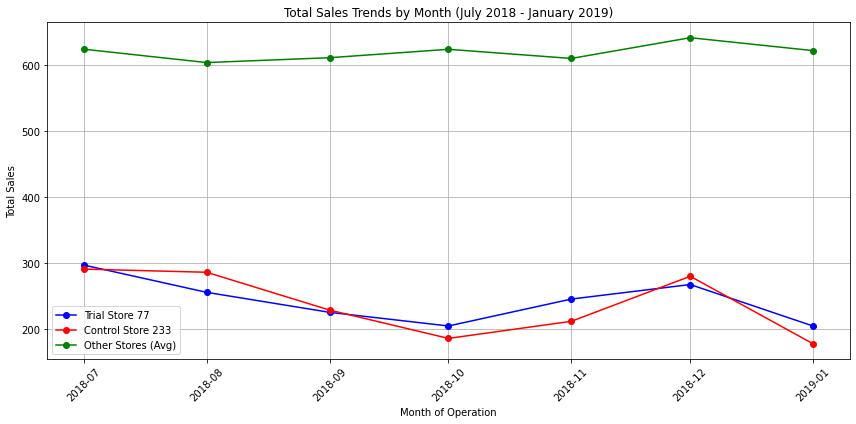

In [55]:
def plot_sales_trends_comparison(sales_data, trial_store, control_store, date_col='DATE', sales_col='TOT_SALES'):
    """
    Plots total sales trends for the trial store, control store, and other stores from July 2018 to January 2019.

    Args:
    sales_data (DataFrame): DataFrame containing sales data for all stores.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure the date column is in datetime format
    sales_data[date_col] = pd.to_datetime(sales_data[date_col])

    # Create a new 'MONTH' column for grouping by month
    sales_data['MONTH'] = sales_data[date_col].dt.to_period('M')

    # Filter data for the date range July 2018 to January 2019
    filtered_data = sales_data[
        (sales_data[date_col] >= '2018-07-01') & (sales_data[date_col] <= '2019-01-31')
    ]

    # Group by store and month to calculate total sales
    grouped_data = filtered_data.groupby(['STORE_NBR', 'MONTH'])[sales_col].sum().reset_index()

    # Separate data for trial, control, and other stores
    trial_data = grouped_data[grouped_data['STORE_NBR'] == trial_store]
    control_data = grouped_data[grouped_data['STORE_NBR'] == control_store]
    other_stores_data = grouped_data[
        (grouped_data['STORE_NBR'] != trial_store) & (grouped_data['STORE_NBR'] != control_store)
    ].groupby('MONTH')[sales_col].mean().reset_index()  # Mean of sales for other stores

    # Plot trends over time
    plt.figure(figsize=(12, 6))
    plt.plot(trial_data['MONTH'].dt.to_timestamp(), trial_data[sales_col], label=f'Trial Store {trial_store}', marker='o', color='blue')
    plt.plot(control_data['MONTH'].dt.to_timestamp(), control_data[sales_col], label=f'Control Store {control_store}', marker='o', color='red')
    plt.plot(other_stores_data['MONTH'].dt.to_timestamp(), other_stores_data[sales_col], label='Other Stores (Avg)', marker='o', color='green')

    # Customize plot
    plt.title('Total Sales Trends by Month (July 2018 - January 2019)')
    plt.xlabel('Month of Operation')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_sales_trends_comparison(
    sales_data=QVI_data,        # Original QVI_data DataFrame
    trial_store=77,             # Trial store number
    control_store=233,          # Selected control store for trial store 77
    date_col='DATE',            # Column representing date
    sales_col='TOT_SALES'       # Column representing sales data
)


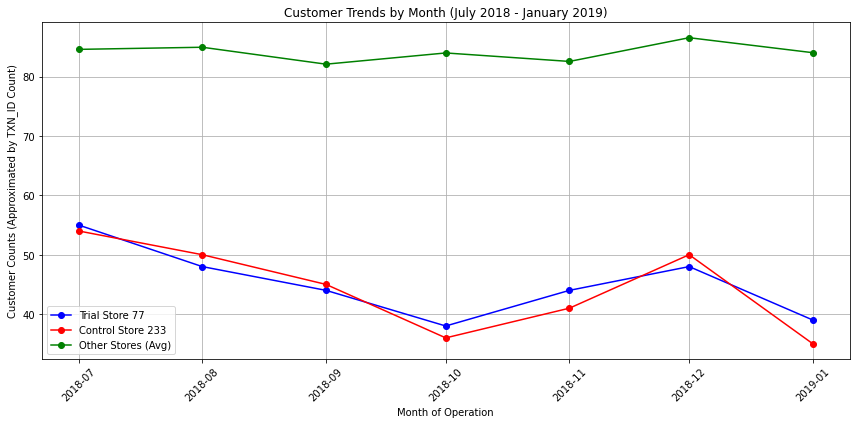

In [56]:
def plot_customer_trends_comparison(transaction_data, trial_store, control_store, date_col='DATE', store_col='STORE_NBR', txn_col='TXN_ID'):
    """
    Plots customer trends based on transaction counts (TXN_ID) for the trial store,
    control store, and other stores from July 2018 to January 2019.

    Args:
    transaction_data (DataFrame): DataFrame containing transaction data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    store_col (str): Column representing store numbers (e.g., STORE_NBR).
    txn_col (str): Column representing transaction IDs.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure the date column is in datetime format
    transaction_data[date_col] = pd.to_datetime(transaction_data[date_col])

    # Create a new 'MONTH' column for grouping by month
    transaction_data['MONTH'] = transaction_data[date_col].dt.to_period('M')

    # Filter data for the date range July 2018 to January 2019
    filtered_data = transaction_data[
        (transaction_data[date_col] >= '2018-07-01') & (transaction_data[date_col] <= '2019-01-31')
    ]

    # Group by store and month to calculate customer counts
    grouped_data = filtered_data.groupby([store_col, 'MONTH'])[txn_col].nunique().reset_index()
    grouped_data.rename(columns={txn_col: 'customer_count'}, inplace=True)

    # Separate data for trial, control, and other stores
    trial_data = grouped_data[grouped_data[store_col] == trial_store]
    control_data = grouped_data[grouped_data[store_col] == control_store]
    other_stores_data = grouped_data[
        (grouped_data[store_col] != trial_store) & (grouped_data[store_col] != control_store)
    ].groupby('MONTH')['customer_count'].mean().reset_index()  # Mean customer count for other stores

    # Plot trends over time
    plt.figure(figsize=(12, 6))
    plt.plot(trial_data['MONTH'].dt.to_timestamp(), trial_data['customer_count'], label=f'Trial Store {trial_store}', marker='o', color='blue')
    plt.plot(control_data['MONTH'].dt.to_timestamp(), control_data['customer_count'], label=f'Control Store {control_store}', marker='o', color='red')
    plt.plot(other_stores_data['MONTH'].dt.to_timestamp(), other_stores_data['customer_count'], label='Other Stores (Avg)', marker='o', color='green')

    # Customize plot
    plt.title('Customer Trends by Month (July 2018 - January 2019)')
    plt.xlabel('Month of Operation')
    plt.ylabel('Customer Counts (Approximated by TXN_ID Count)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage for customer counts
plot_customer_trends_comparison(
    transaction_data=QVI_data,   # Original QVI_data DataFrame
    trial_store=77,              # Trial store number
    control_store=233,           # Selected control store for trial store 77
    date_col='DATE',             # Column representing date
    store_col='STORE_NBR',       # Column representing store numbers
    txn_col='TXN_ID'             # Column representing transaction IDs
)


In [57]:
def scale_control_sales(data, trial_store, control_store, date_col='DATE', sales_col='TOT'):
    """
    Scales the control store's pre-trial sales to match the trial store's sales.

    Args:
    data (DataFrame): Full DataFrame containing sales data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    DataFrame: Updated DataFrame with scaled control sales for the pre-trial period.
    float: Scaling factor used to align control store sales with trial store sales.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the pre-trial period (July 2018 to January 2019)
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Confirm rows exist for trial store and control store
    if pretrial_period_data[pretrial_period_data['STORE_NBR'] == trial_store].empty:
        print(f"No data found for trial store {trial_store} in the pre-trial period.")
        return pretrial_period_data, None

    if pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store].empty:
        print(f"No data found for control store {control_store} in the pre-trial period.")
        return pretrial_period_data, None

    # Calculate total sales for the pre-trial period for both stores
    trial_store_total_sales = pretrial_period_data[pretrial_period_data['STORE_NBR'] == trial_store][sales_col].sum()
    control_store_total_sales = pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store][sales_col].sum()

    # Check for missing or zero sales
    if trial_store_total_sales == 0 or control_store_total_sales == 0:
        print(f"Sales data is missing or zero for trial store {trial_store} or control store {control_store}.")
        return pretrial_period_data, None

    # Calculate scaling factor
    scaling_factor = trial_store_total_sales / control_store_total_sales
    print(f"Scaling Factor: {scaling_factor}")

    # Apply scaling factor to the control store's sales
    pretrial_period_data['scaled_sales'] = pretrial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Check scaled_sales column for control store
    print(pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store][['DATE', sales_col, 'scaled_sales']])

    return pretrial_period_data, scaling_factor

# Example usage
scaled_data, scaling_factor = scale_control_sales(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=77,          # Trial store number
    control_store=233,       # Control store number
    date_col='DATE',         # Column representing the date
    sales_col='TOT_SALES'          # Column representing sales data (TOT)
)

print(f"Scaling Factor: {scaling_factor}")
print("Scaled Pre-Trial Data:")
print(scaled_data.head())


Scaling Factor: 1.0236173032895528
             DATE  TOT_SALES  scaled_sales
231945 2018-10-03        3.7      3.787384
231946 2018-12-24        3.0      3.070852
231947 2018-09-08        4.6      4.708640
231950 2018-10-27        3.4      3.480299
231951 2018-08-19        1.7      1.740149
...           ...        ...           ...
232473 2018-10-05        3.0      3.070852
232474 2018-10-31       10.2     10.440896
232477 2018-08-09        3.8      3.889746
232478 2018-12-05        4.6      4.708640
232479 2018-11-26        2.7      2.763767

[311 rows x 3 columns]
Scaling Factor: 1.0236173032895528
Scaled Pre-Trial Data:
   LYLTY_CARD_NBR       DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000 2018-10-17          1       1         5   
1            1002 2018-09-16          1       2        58   
4            1004 2018-11-02          1       5        96   
5            1005 2018-12-28          1       6        86   
6            1007 2018-12-04          1       7        49   



In [58]:
# Ensure the DATE column is in datetime format
QVI_data['DATE'] = pd.to_datetime(QVI_data['DATE'])

# Filter the data for the pre-trial period (July 2018 to January 2019)
pretrial_period_data = QVI_data[
    (QVI_data['DATE'] >= '2018-07-01') & (QVI_data['DATE'] <= '2019-01-31')
]

# Print rows where STORE_NBR is 233 (control store)
print(pretrial_period_data[pretrial_period_data['STORE_NBR'] == 233])

        LYLTY_CARD_NBR       DATE  STORE_NBR  TXN_ID  PROD_NBR  \
231945          233000 2018-10-03        233  236715       109   
231946          233005 2018-12-24        233  236720        37   
231947          233006 2018-09-08        233  236721       108   
231950          233010 2018-10-27        233  236725        55   
231951          233011 2018-08-19        233  236726        55   
...                ...        ...        ...     ...       ...   
232473          233489 2018-10-05        233  237271        76   
232474          233490 2018-10-31        233  237272        65   
232477          233492 2018-08-09        233  237275        33   
232478          233494 2018-12-05        233  237276       113   
232479          233495 2018-11-26        233  237277        13   

                                       PROD_NAME  PROD_QTY  TOT_SALES  \
231945                  Pringles Barbeque   134g         1        3.7   
231946  Smiths Thinly       Swt Chli&S/Cream175G         1   

In [59]:
def analyze_trial_sales(data, trial_store, control_store, scaling_factor, date_col='DATE', sales_col='TOT'):
    """
    Analyzes sales during the trial period to check for an uplift in trial store sales.

    Args:
    data (DataFrame): Full DataFrame containing sales data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    DataFrame: DataFrame containing trial period sales data for comparison.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the trial period (February 2019 to April 2019)
    trial_period_data = data[
        (data[date_col] >= '2019-02-01') & (data[date_col] <= '2019-04-30')
    ].copy()

    # Scale the control store's sales during the trial period
    trial_period_data['scaled_sales'] = trial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Aggregate total sales for the trial store and scaled control store
    trial_sales = trial_period_data[trial_period_data['STORE_NBR'] == trial_store][sales_col].sum()
    control_scaled_sales = trial_period_data[trial_period_data['STORE_NBR'] == control_store]['scaled_sales'].sum()

    # Print results for comparison
    print(f"Total Sales for Trial Store {trial_store} during trial period: {trial_sales}")
    print(f"Total Scaled Sales for Control Store {control_store} during trial period: {control_scaled_sales}")

    # Add a summary for better comparison
    trial_period_summary = pd.DataFrame({
        'Store': ['Trial Store', 'Control Store (Scaled)'],
        'Total Sales': [trial_sales, control_scaled_sales]
    })

    return trial_period_summary

# Example usage
trial_sales_summary = analyze_trial_sales(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=77,          # Trial store number
    control_store=233,       # Control store number
    scaling_factor=scaling_factor,  # Scaling factor from pre-trial analysis
    date_col='DATE',         # Column representing the date
    sales_col='TOT_SALES'          # Column representing sales data (TOT)
)

print("Trial Period Sales Summary:")
print(trial_sales_summary)


Total Sales for Trial Store 77 during trial period: 777.0
Total Scaled Sales for Control Store 233 during trial period: 615.910531389324
Trial Period Sales Summary:
                    Store  Total Sales
0             Trial Store   777.000000
1  Control Store (Scaled)   615.910531


In [60]:
#Percentage Difference

# Sales values from the trial period
trial_store_sales = 777.0  # Total sales for Trial Store 77
scaled_control_store_sales = 615.910531  # Total scaled sales for Control Store 233

# Calculate percentage difference
percentage_difference = ((trial_store_sales - scaled_control_store_sales) / scaled_control_store_sales) * 100

# Print the result
print(f"Percentage Difference: {percentage_difference:.2f}%")

Percentage Difference: 26.15%


In [61]:
#Standard Deviation

def calculate_pretrial_std_simple(data, trial_store, control_store, scaling_factor, date_col='DATE', sales_col='TOT'):
    """
    Simplifies the calculation of standard deviation of percentage differences in the pre-trial period.

    Args:
    data (DataFrame): Full DataFrame containing sales data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    float: Standard deviation of the scaled percentage differences.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the pre-trial period (July 2018 to January 2019)
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Scale the control store's sales during the pre-trial period
    pretrial_period_data['scaled_sales'] = pretrial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Calculate percentage differences
    pretrial_period_data['percentage_difference'] = (
        (pretrial_period_data[sales_col] - pretrial_period_data['scaled_sales']) / pretrial_period_data['scaled_sales']
    ) * 100

    # Calculate and return standard deviation of percentage differences
    std_dev = pretrial_period_data['percentage_difference'].std()

    return std_dev

# Example usage
pretrial_std_dev_simple = calculate_pretrial_std_simple(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=77,          # Trial store number
    control_store=233,       # Control store number
    scaling_factor=scaling_factor,  # Scaling factor from pre-trial analysis
    date_col='DATE',         # Column representing the date
    sales_col='TOT_SALES'          # Column representing sales data (TOT)
)

print(f"Pre-Trial Standard Deviation (Simplified): {pretrial_std_dev_simple:.2f}%")

Pre-Trial Standard Deviation (Simplified): 0.10%


In [85]:
import scipy.stats as stats

def calculate_t_values_and_critical_t(trial_data, trial_store, control_store, scaling_factor, pretrial_std, date_col='DATE', sales_col='TOT'):
    """
    Calculates t-values for trial months and finds the 95th percentile of the t-distribution.

    Args:
    trial_data (DataFrame): DataFrame containing trial period data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    pretrial_std (float): Standard deviation from pre-trial period.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    DataFrame: DataFrame with t-values for each trial month.
    float: 95th percentile (critical t-value) of the t-distribution.
    """
    # Ensure the date column is in datetime format
    trial_data[date_col] = pd.to_datetime(trial_data[date_col])

    # Filter for the trial period (February 2019 to April 2019)
    trial_period_data = trial_data[
        (trial_data[date_col] >= '2019-02-01') & (trial_data[date_col] <= '2019-04-30')
    ].copy()

    # Scale the control store's sales during the trial period
    trial_period_data['scaled_sales'] = trial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Aggregate monthly sales for trial store and scaled control store
    monthly_sales = trial_period_data.groupby([date_col, 'STORE_NBR']).agg(
        {sales_col: 'sum', 'scaled_sales': 'sum'}).reset_index()

    # Filter for trial store and scaled control store
    trial_store_sales = monthly_sales[monthly_sales['STORE_NBR'] == trial_store]
    control_store_scaled_sales = monthly_sales[monthly_sales['STORE_NBR'] == control_store]

    # Merge trial store and control store sales by date
    merged_sales = trial_store_sales.merge(
        control_store_scaled_sales,
        on=date_col,
        suffixes=('_trial', '_control')
    )

    # Calculate observed difference and standard error
    merged_sales['observed_difference'] = merged_sales[f"{sales_col}_trial"] - merged_sales['scaled_sales_control']
    standard_error = pretrial_std / (8**0.5)  # 8 is the pre-trial period length
    merged_sales['t_value'] = merged_sales['observed_difference'] / standard_error

    # Calculate the 95th percentile of the t-distribution with 7 degrees of freedom
    degrees_of_freedom = 7
    critical_t = stats.t.ppf(0.95, df=degrees_of_freedom)

    print("T-Values for Trial Months:")
    print(merged_sales[['DATE', 'observed_difference', 't_value']])
    print(f"\nCritical T-Value (95th Percentile): {critical_t:.2f}")

    return merged_sales[['DATE', 'observed_difference', 't_value']], critical_t

# Example usage
trial_t_values, critical_t_value = calculate_t_values_and_critical_t(
    trial_data=QVI_data,           # Full QVI_data DataFrame
    trial_store=77,                # Trial store number
    control_store=233,             # Control store number
    scaling_factor=scaling_factor, # Scaling factor from pre-trial analysis
    pretrial_std=pretrial_std_dev_simple, # Standard deviation from pre-trial period
    date_col='DATE',               # Column representing the date
    sales_col='TOT_SALES'                # Column representing sales data (TOT)
)

print("\nT-Values and Critical T-Value for Trial Period:")
print(trial_t_values)
print(f"Critical T-Value: {critical_t_value:.2f}")

T-Values for Trial Months:
         DATE  observed_difference     t_value
0  2019-02-01             0.354380    9.734833
1  2019-02-02             2.258296   62.035482
2  2019-02-03            13.967743  383.694437
3  2019-02-04            -2.203916  -60.541660
4  2019-02-05            10.431510  286.553973
5  2019-02-06           -15.350283 -421.672865
6  2019-02-09             3.487444   95.800227
7  2019-02-10             1.575636   43.282771
8  2019-02-11            -0.988938  -27.166176
9  2019-02-13             1.258296   34.565444
10 2019-02-14            -1.799940  -49.444414
11 2019-02-16           -16.003049 -439.604355
12 2019-02-17             2.696084   74.061527
13 2019-02-19             8.710254  239.271017
14 2019-02-20            -0.001494   -0.041045
15 2019-02-21           -11.135366 -305.888921
16 2019-02-22            11.631510  319.518019
17 2019-02-23             1.436233   39.453383
18 2019-02-26             2.943318   80.853071
19 2019-02-27             6.34810

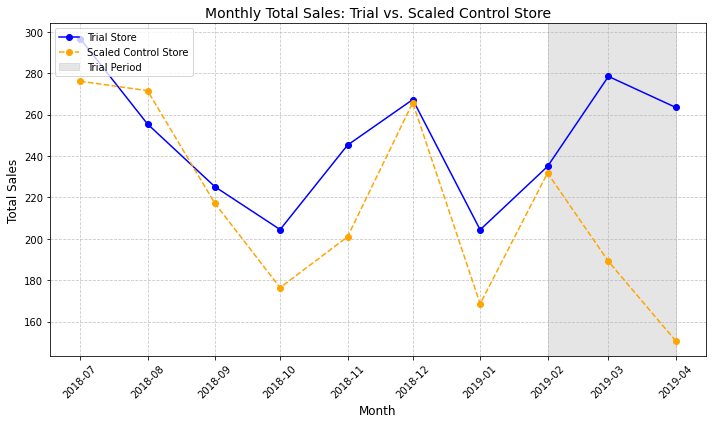

In [65]:
from matplotlib.patches import Rectangle

def plot_monthly_total_sales(pretrial_data, trial_data, trial_store, control_store, scaling_factor, date_col='DATE', sales_col='TOT_SALES'):
    """
    Plots monthly total sales for trial and scaled control stores, highlighting the trial period.

    Args:
    pretrial_data (DataFrame): DataFrame with pre-trial total sales.
    trial_data (DataFrame): DataFrame with trial period total sales.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    date_col (str): Column representing the date.
    sales_col (str): Column representing total sales.
    """
    # Combine pre-trial and trial data
    combined_data = pd.concat([pretrial_data, trial_data])

    # Ensure the date column is in datetime format
    combined_data[date_col] = pd.to_datetime(combined_data[date_col])

    # Create a new 'MONTH' column for grouping
    combined_data['MONTH'] = combined_data[date_col].dt.to_period('M')

    # Aggregate total sales by store and month
    monthly_sales = combined_data.groupby(['MONTH', 'STORE_NBR'])[sales_col].sum().reset_index()

    # Separate trial and control store data
    trial_store_sales = monthly_sales[monthly_sales['STORE_NBR'] == trial_store].copy()
    control_store_sales = monthly_sales[monthly_sales['STORE_NBR'] == control_store].copy()

    # Apply scaling factor to control store sales
    control_store_sales['scaled_sales'] = control_store_sales[sales_col] * scaling_factor

    # Plot the data
    plt.figure(figsize=(10, 6))

    # Plot trial store total sales
    plt.plot(trial_store_sales['MONTH'].dt.to_timestamp(), trial_store_sales[sales_col], label='Trial Store', color='blue', marker='o')

    # Plot scaled control store total sales
    plt.plot(control_store_sales['MONTH'].dt.to_timestamp(), control_store_sales['scaled_sales'], label='Scaled Control Store', color='orange', linestyle='--', marker='o')

    # Highlight trial period (February 2019 to April 2019)
    trial_period_start = pd.to_datetime('2019-02')
    trial_period_end = pd.to_datetime('2019-04')
    plt.axvspan(trial_period_start, trial_period_end, color='gray', alpha=0.2, label='Trial Period')

    # Add labels, title, and legend
    plt.title('Monthly Total Sales: Trial vs. Scaled Control Store', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Total Sales', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
plot_monthly_total_sales(
    pretrial_data=QVI_data[QVI_data['DATE'] < '2019-02-01'],  # Pre-trial data
    trial_data=QVI_data[(QVI_data['DATE'] >= '2019-02-01') & (QVI_data['DATE'] <= '2019-04-30')],  # Trial data
    trial_store=77,                 # Trial store number
    control_store=233,              # Control store number
    scaling_factor=0.95,            # Example scaling factor
    date_col='DATE',                # Column representing the date
    sales_col='TOT_SALES'           # Column representing total sales
)


In [66]:
def assess_customer_counts_fixed(data, trial_store, control_store, date_col='DATE', txn_col='TXN_ID'):
    """
    Fix the calculation of scaling factor, apply it correctly to control store customer counts,
    and calculate percentage difference during the trial period.

    Args:
    data (DataFrame): Full DataFrame containing transaction data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    txn_col (str): Column representing transaction IDs (proxy for customer counts).

    Returns:
    tuple: Scaling factor, percentage differences for the trial period, and aggregated summary.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Step 1: Compute Scaling Factor for Pre-Trial Period
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Aggregate transaction counts (proxy for customer counts) for pre-trial period
    trial_store_customers_pretrial = pretrial_period_data[pretrial_period_data['STORE_NBR'] == trial_store][txn_col].count()
    control_store_customers_pretrial = pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store][txn_col].count()

    # Compute scaling factor
    scaling_factor = trial_store_customers_pretrial / control_store_customers_pretrial

    # Step 2: Apply Scaling Factor to Trial Period
    trial_period_data = data[
        (data[date_col] >= '2019-02-01') & (data[date_col] <= '2019-04-30')
    ].copy()

    # Aggregate transaction counts (proxy for customer counts) for trial period
    trial_store_customers_trial = trial_period_data[trial_period_data['STORE_NBR'] == trial_store][txn_col].count()
    control_store_customers_trial = trial_period_data[trial_period_data['STORE_NBR'] == control_store][txn_col].count()

    # Scale control store customer counts
    control_store_customers_trial_scaled = control_store_customers_trial * scaling_factor

    # Step 3: Calculate Percentage Differences
    percentage_difference = (
        (trial_store_customers_trial - control_store_customers_trial_scaled) / control_store_customers_trial_scaled
    ) * 100

    # Aggregated summary
    summary = pd.DataFrame({
        'Store': ['Trial Store', 'Control Store (Scaled)'],
        'Customer Counts': [trial_store_customers_trial, control_store_customers_trial_scaled],
        'Percentage Difference': [percentage_difference, None]
    })

    print(f"Scaling Factor: {scaling_factor:.2f}")
    print("\nTrial Period Customer Counts Summary:")
    print(summary)

    return scaling_factor, percentage_difference, summary

# Example usage
customer_scaling_factor_fixed, customer_percentage_difference_fixed, customer_summary_fixed = assess_customer_counts_fixed(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=77,          # Trial store number
    control_store=233,       # Control store number
    date_col='DATE',         # Column representing the date
    txn_col='TXN_ID'         # Column representing transaction IDs (customer proxy)
)

print(f"Customer Scaling Factor (Fixed): {customer_scaling_factor_fixed:.2f}")
print(f"Percentage Difference Between Trial Store and Scaled Control Store (Fixed): {customer_percentage_difference_fixed:.2f}%")


Scaling Factor: 1.02

Trial Period Customer Counts Summary:
                    Store  Customer Counts  Percentage Difference
0             Trial Store       148.000000              19.998957
1  Control Store (Scaled)       123.334405                    NaN
Customer Scaling Factor (Fixed): 1.02
Percentage Difference Between Trial Store and Scaled Control Store (Fixed): 20.00%


In [67]:
import pandas as pd

def calculate_pretrial_customer_std_fixed(data, trial_store, control_store, scaling_factor, date_col='DATE', txn_col='TXN_ID'):
    """
    Calculate the standard deviation of scaled percentage differences for customer counts during the pre-trial period.

    Args:
    data (DataFrame): Full DataFrame containing transaction data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store.
    date_col (str): Column representing the date (e.g., DATE).
    txn_col (str): Column representing transaction IDs (proxy for customer counts).

    Returns:
    float: Standard deviation of scaled percentage differences.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the pre-trial period (July 2018 to January 2019)
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Aggregate customer counts (transactions) by store and month
    monthly_customers = pretrial_period_data.groupby([date_col, 'STORE_NBR'])[txn_col].count().reset_index()

    # Separate trial and control store data
    trial_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == trial_store].copy()
    control_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == control_store].copy()

    # Scale control store customer counts
    control_store_customers.loc[:, 'scaled_customers'] = control_store_customers[txn_col] * scaling_factor

    # Merge trial and scaled control store data by date
    merged_customers = trial_store_customers.merge(
        control_store_customers,
        on=date_col,
        suffixes=('_trial', '_control')
    )

    # Calculate percentage differences
    merged_customers['percentage_difference'] = (
        (merged_customers[f"{txn_col}_trial"] - merged_customers['scaled_customers']) /
        merged_customers['scaled_customers']
    ) * 100

    # Calculate standard deviation of percentage differences
    std_dev = merged_customers['percentage_difference'].std()

    print("Percentage Differences for Pre-Trial Period:")
    print(merged_customers[['DATE', 'percentage_difference']])
    print(f"\nStandard Deviation of Percentage Differences: {std_dev:.2f}%")

    return std_dev

# Example usage
pretrial_customer_std_dev_fixed = calculate_pretrial_customer_std_fixed(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=77,          # Trial store number
    control_store=233,       # Control store number
    scaling_factor=customer_scaling_factor_fixed,  # Scaling factor for customers
    date_col='DATE',         # Column representing the date
    txn_col='TXN_ID'         # Column representing transaction IDs (customer proxy)
)

print(f"\nPre-Trial Customer Standard Deviation (Fixed): {pretrial_customer_std_dev_fixed:.2f}%")


Percentage Differences for Pre-Trial Period:
          DATE  percentage_difference
0   2018-07-01              96.214511
1   2018-07-03             -50.946372
2   2018-07-05              96.214511
3   2018-07-06             -50.946372
4   2018-07-07             292.429022
..         ...                    ...
120 2019-01-21              -1.892744
121 2019-01-23              96.214511
122 2019-01-24             -67.297581
123 2019-01-26              -1.892744
124 2019-01-30             -50.946372

[125 rows x 2 columns]

Standard Deviation of Percentage Differences: 97.45%

Pre-Trial Customer Standard Deviation (Fixed): 97.45%


In [70]:
def hypothesis_test_customers_fixed(data, trial_store, control_store, scaling_factor, pretrial_std_dev, date_col='DATE', txn_col='TXN_ID'):
    """
    Conduct hypothesis testing for customer counts during the trial period using pre-trial standard deviation.

    Args:
    data (DataFrame): DataFrame containing trial period data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store customer counts.
    pretrial_std_dev (float): Pre-trial standard deviation of percentage differences.
    date_col (str): Column representing the date (e.g., DATE).
    txn_col (str): Column representing transaction IDs (proxy for customer counts).

    Returns:
    tuple: DataFrame with t-values and the critical t-value for the trial period.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the trial period (February 2019 to April 2019)
    trial_period_data = data[
        (data[date_col] >= '2019-02-01') & (data[date_col] <= '2019-04-30')
    ].copy()

    # Aggregate customer counts (transactions) by store and month
    monthly_customers = trial_period_data.groupby([date_col, 'STORE_NBR'])[txn_col].count().reset_index()

    # Separate trial and control store data
    trial_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == trial_store].copy()
    control_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == control_store].copy()

    # Scale control store customer counts safely
    control_store_customers.loc[:, 'scaled_customers'] = control_store_customers[txn_col] * scaling_factor

    # Merge trial store and scaled control store data by date
    merged_customers = trial_store_customers.merge(
        control_store_customers,
        on=date_col,
        suffixes=('_trial', '_control')
    )

    # Calculate observed differences
    merged_customers['observed_difference'] = merged_customers[f"{txn_col}_trial"] - merged_customers['scaled_customers']

    # Calculate standard error
    standard_error = pretrial_std_dev / (8**0.5)  # Square root of pre-trial months (8)

    # Calculate t-values
    merged_customers['t_value'] = merged_customers['observed_difference'] / standard_error

    # Calculate critical t-value at 95th percentile with degrees of freedom = 7
    degrees_of_freedom = 7
    critical_t_value = stats.t.ppf(0.95, df=degrees_of_freedom)

    print("\nT-Values for Trial Months:")
    print(merged_customers[['DATE', 'observed_difference', 't_value']])
    print(f"\nCritical T-Value (95th Percentile): {critical_t_value:.2f}")

    return merged_customers[['DATE', 'observed_difference', 't_value']], critical_t_value

# Example usage
customer_t_values_fixed, customer_critical_t_value_fixed = hypothesis_test_customers_fixed(
    data=QVI_data,                  # Full QVI_data DataFrame
    trial_store=77,                 # Trial store number
    control_store=233,              # Control store number
    scaling_factor=customer_scaling_factor_fixed, # Scaling factor from customers
    pretrial_std_dev=pretrial_customer_std_dev_fixed,  # Pre-trial standard deviation
    date_col='DATE',                # Column representing the date
    txn_col='TXN_ID'                # Column representing transaction IDs (customer proxy)
)

print("\nT-Values and Critical T-Value for Trial Period (Customers):")
print(customer_t_values_fixed)
print(f"Critical T-Value: {customer_critical_t_value_fixed:.2f}")



T-Values for Trial Months:
         DATE  observed_difference   t_value
0  2019-02-01            -0.038585 -0.001120
1  2019-02-02             0.980707  0.028463
2  2019-02-03             2.980707  0.086510
3  2019-02-04            -0.019293 -0.000560
4  2019-02-05             0.980707  0.028463
5  2019-02-06            -0.057878 -0.001680
6  2019-02-09            -0.038585 -0.001120
7  2019-02-10            -1.057878 -0.030703
8  2019-02-11            -1.038585 -0.030143
9  2019-02-13            -0.019293 -0.000560
10 2019-02-14            -1.057878 -0.030703
11 2019-02-16            -3.077170 -0.089310
12 2019-02-17             0.980707  0.028463
13 2019-02-19             0.980707  0.028463
14 2019-02-20            -0.057878 -0.001680
15 2019-02-21            -1.038585 -0.030143
16 2019-02-22             2.980707  0.086510
17 2019-02-23            -0.019293 -0.000560
18 2019-02-26            -0.019293 -0.000560
19 2019-02-27            -1.057878 -0.030703
20 2019-02-28            -1

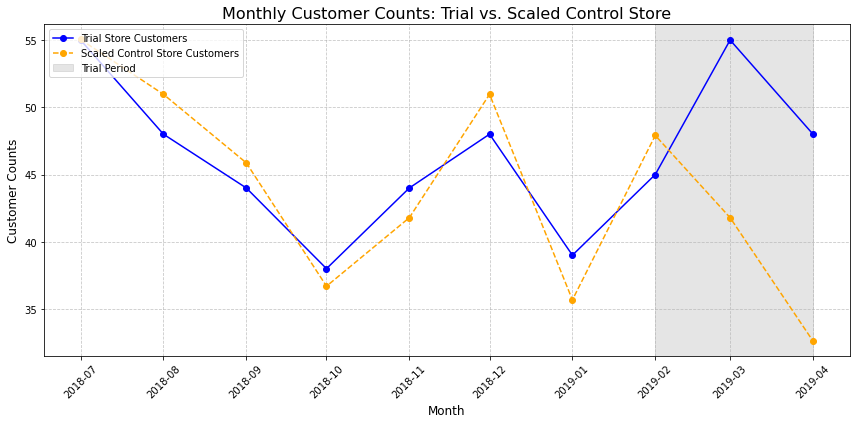

In [71]:
def plot_monthly_customer_counts(pretrial_data, trial_data, trial_store, control_store, scaling_factor, date_col='DATE', txn_col='TXN_ID'):
    """
    Plots monthly customer counts for trial and control stores, highlighting the trial period.

    Args:
    pretrial_data (DataFrame): DataFrame with pre-trial customer counts.
    trial_data (DataFrame): DataFrame with trial period customer counts.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store customer counts.
    date_col (str): Column representing the date.
    txn_col (str): Column representing transaction counts (customer counts).
    """
    # Combine pre-trial and trial data
    combined_data = pd.concat([pretrial_data, trial_data])

    # Ensure the date column is in datetime format
    combined_data[date_col] = pd.to_datetime(combined_data[date_col])

    # Create a new 'MONTH' column for grouping
    combined_data['MONTH'] = combined_data[date_col].dt.to_period('M')

    # Aggregate customer counts by month for both stores
    monthly_customers = combined_data.groupby(['MONTH', 'STORE_NBR'])[txn_col].nunique().reset_index()
    monthly_customers.rename(columns={txn_col: 'customer_count'}, inplace=True)

    # Separate trial and control stores
    trial_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == trial_store].copy()
    control_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == control_store].copy()

    # Apply scaling factor to control store counts
    control_store_customers['scaled_customers'] = control_store_customers['customer_count'] * scaling_factor

    # Plot the data
    plt.figure(figsize=(12, 6))

    # Plot trial store monthly customer counts
    plt.plot(trial_store_customers['MONTH'].dt.to_timestamp(), trial_store_customers['customer_count'], label='Trial Store Customers', color='blue', marker='o')

    # Plot scaled control store monthly customer counts
    plt.plot(control_store_customers['MONTH'].dt.to_timestamp(), control_store_customers['scaled_customers'], label='Scaled Control Store Customers', color='orange', linestyle='--', marker='o')

    # Highlight trial period (February 2019 to April 2019)
    trial_period_start = pd.to_datetime('2019-02')
    trial_period_end = pd.to_datetime('2019-04')
    plt.axvspan(trial_period_start, trial_period_end, color='gray', alpha=0.2, label='Trial Period')

    # Add labels, title, and legend
    plt.title('Monthly Customer Counts: Trial vs. Scaled Control Store', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Customer Counts', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
plot_monthly_customer_counts(
    pretrial_data=QVI_data[QVI_data['DATE'] < '2019-02-01'],  # Pre-trial data
    trial_data=QVI_data[(QVI_data['DATE'] >= '2019-02-01') & (QVI_data['DATE'] <= '2019-04-30')],  # Trial data
    trial_store=77,                 # Trial store number
    control_store=233,              # Control store number
    scaling_factor=customer_scaling_factor_fixed,  # Scaling factor for customers
    date_col='DATE',                # Column representing the date
    txn_col='TXN_ID'                # Column representing transaction counts (proxy for customers)
)

## Now for trial store 86

In [72]:
# Add trial_store to customers_correlation
customers_correlation['trial_store'] = 86

# Rename STORE_NBR to control_store for consistency
customers_correlation.rename(columns={'STORE_NBR': 'control_store'}, inplace=True)

In [73]:
customers_combined = calculate_combined_score(
    correlation_df=customers_correlation,
    magnitude_df=customers_magnitude,
    corr_weight=0.5  # Adjust the correlation weight as needed
)

print("Combined score for monthly number of customers:")
print(customers_combined)

Combined score for monthly number of customers:
     control_store  correlation  trial_store  standardized_magnitude  \
0                1     0.322168           86               72.306818   
1                1     0.485831           86               72.306818   
2                1     0.305334           86               72.306818   
3                2    -0.572051           86               80.869467   
4                2    -0.086161           86               80.869467   
..             ...          ...          ...                     ...   
770            272     0.223217           86               75.161034   
771            272    -0.353815           86               75.161034   
772            272     0.026909           86               75.161034   
773             77    -0.267305           86               75.731877   
774             77     0.765048           86               75.731877   

     combined_score  
0          0.167999  
1          0.249831  
2          0.159582  

In [74]:
# Merge sales_combined and customers_combined on trial_store and control_store
final_combined_scores = pd.merge(
    sales_combined[['trial_store', 'control_store', 'combined_score']],
    customers_combined[['trial_store', 'control_store', 'combined_score']],
    on=['trial_store', 'control_store'],
    suffixes=('_sales', '_customers')
)

# Calculate the simple average of the scores
final_combined_scores['average_score'] = (
    final_combined_scores['combined_score_sales'] + final_combined_scores['combined_score_customers']
) / 2

# Display the final combined scores
print("Final Combined Scores:")
print(final_combined_scores)


Final Combined Scores:
     trial_store  control_store  combined_score_sales  \
0             86              1              0.229452   
1             86              1              0.229452   
2             86              1              0.229452   
3             86              2             -0.195625   
4             86              2             -0.195625   
..           ...            ...                   ...   
770           86            271              0.328508   
771           86            271              0.328508   
772           86            272              0.011768   
773           86            272              0.011768   
774           86            272              0.011768   

     combined_score_customers  average_score  
0                    0.167999       0.198726  
1                    0.249831       0.239641  
2                    0.159582       0.194517  
3                   -0.279843      -0.237734  
4                   -0.036898      -0.116261  
..        

In [75]:
# Select the control store with the highest combined score for each trial store
def select_control_store(final_scores, trial_store):
    """
    Select the control store with the highest combined score for a given trial store,
    excluding the trial store itself.

    Args:
    final_scores (DataFrame): The DataFrame with combined scores for trial and control stores.
    trial_store (int): The trial store number to find the control store for.

    Returns:
    DataFrame: The row corresponding to the best-matching control store.
    """
    # Filter for the given trial store and exclude the trial store itself as control store
    filtered_scores = final_scores[final_scores['trial_store'] == trial_store]
    filtered_scores = filtered_scores[filtered_scores['control_store'] != trial_store]

    # Sort by combined_score in descending order
    best_control_store = filtered_scores.sort_values(by='combined_score', ascending=False).iloc[0]

    return best_control_store

# Example for trial store 77
best_store_86 = select_control_store(customers_combined, trial_store=86)

print("Best Control Store for Trial Store 86:")
print(best_store_86)


Best Control Store for Trial Store 86:
control_store             155.000000
correlation                 0.942876
trial_store                86.000000
standardized_magnitude      1.902811
combined_score              0.734207
Name: 435, dtype: float64


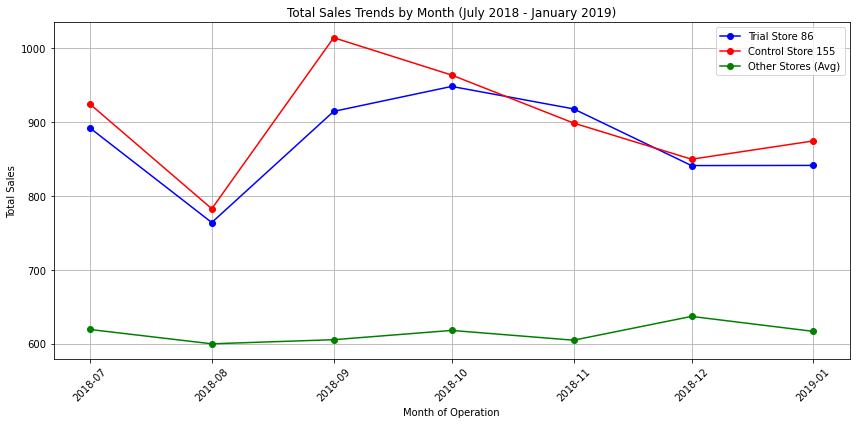

In [76]:
def plot_sales_trends_comparison(sales_data, trial_store, control_store, date_col='DATE', sales_col='TOT_SALES'):
    """
    Plots total sales trends for the trial store, control store, and other stores from July 2018 to January 2019.

    Args:
    sales_data (DataFrame): DataFrame containing sales data for all stores.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure the date column is in datetime format
    sales_data[date_col] = pd.to_datetime(sales_data[date_col])

    # Create a new 'MONTH' column for grouping by month
    sales_data['MONTH'] = sales_data[date_col].dt.to_period('M')

    # Filter data for the date range July 2018 to January 2019
    filtered_data = sales_data[
        (sales_data[date_col] >= '2018-07-01') & (sales_data[date_col] <= '2019-01-31')
    ]

    # Group by store and month to calculate total sales
    grouped_data = filtered_data.groupby(['STORE_NBR', 'MONTH'])[sales_col].sum().reset_index()

    # Separate data for trial, control, and other stores
    trial_data = grouped_data[grouped_data['STORE_NBR'] == trial_store]
    control_data = grouped_data[grouped_data['STORE_NBR'] == control_store]
    other_stores_data = grouped_data[
        (grouped_data['STORE_NBR'] != trial_store) & (grouped_data['STORE_NBR'] != control_store)
    ].groupby('MONTH')[sales_col].mean().reset_index()  # Mean of sales for other stores

    # Plot trends over time
    plt.figure(figsize=(12, 6))
    plt.plot(trial_data['MONTH'].dt.to_timestamp(), trial_data[sales_col], label=f'Trial Store {trial_store}', marker='o', color='blue')
    plt.plot(control_data['MONTH'].dt.to_timestamp(), control_data[sales_col], label=f'Control Store {control_store}', marker='o', color='red')
    plt.plot(other_stores_data['MONTH'].dt.to_timestamp(), other_stores_data[sales_col], label='Other Stores (Avg)', marker='o', color='green')

    # Customize plot
    plt.title('Total Sales Trends by Month (July 2018 - January 2019)')
    plt.xlabel('Month of Operation')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_sales_trends_comparison(
    sales_data=QVI_data,        # Original QVI_data DataFrame
    trial_store=86,             # Trial store number
    control_store=155,          # Selected control store for trial store 77
    date_col='DATE',            # Column representing date
    sales_col='TOT_SALES'       # Column representing sales data
)


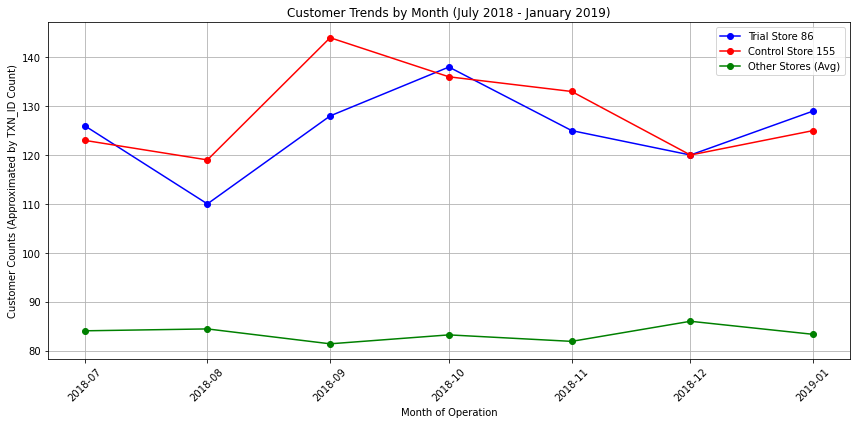

In [77]:
def plot_customer_trends_comparison(transaction_data, trial_store, control_store, date_col='DATE', store_col='STORE_NBR', txn_col='TXN_ID'):
    """
    Plots customer trends based on transaction counts (TXN_ID) for the trial store,
    control store, and other stores from July 2018 to January 2019.

    Args:
    transaction_data (DataFrame): DataFrame containing transaction data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    store_col (str): Column representing store numbers (e.g., STORE_NBR).
    txn_col (str): Column representing transaction IDs.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure the date column is in datetime format
    transaction_data[date_col] = pd.to_datetime(transaction_data[date_col])

    # Create a new 'MONTH' column for grouping by month
    transaction_data['MONTH'] = transaction_data[date_col].dt.to_period('M')

    # Filter data for the date range July 2018 to January 2019
    filtered_data = transaction_data[
        (transaction_data[date_col] >= '2018-07-01') & (transaction_data[date_col] <= '2019-01-31')
    ]

    # Group by store and month to calculate customer counts
    grouped_data = filtered_data.groupby([store_col, 'MONTH'])[txn_col].nunique().reset_index()
    grouped_data.rename(columns={txn_col: 'customer_count'}, inplace=True)

    # Separate data for trial, control, and other stores
    trial_data = grouped_data[grouped_data[store_col] == trial_store]
    control_data = grouped_data[grouped_data[store_col] == control_store]
    other_stores_data = grouped_data[
        (grouped_data[store_col] != trial_store) & (grouped_data[store_col] != control_store)
    ].groupby('MONTH')['customer_count'].mean().reset_index()  # Mean customer count for other stores

    # Plot trends over time
    plt.figure(figsize=(12, 6))
    plt.plot(trial_data['MONTH'].dt.to_timestamp(), trial_data['customer_count'], label=f'Trial Store {trial_store}', marker='o', color='blue')
    plt.plot(control_data['MONTH'].dt.to_timestamp(), control_data['customer_count'], label=f'Control Store {control_store}', marker='o', color='red')
    plt.plot(other_stores_data['MONTH'].dt.to_timestamp(), other_stores_data['customer_count'], label='Other Stores (Avg)', marker='o', color='green')

    # Customize plot
    plt.title('Customer Trends by Month (July 2018 - January 2019)')
    plt.xlabel('Month of Operation')
    plt.ylabel('Customer Counts (Approximated by TXN_ID Count)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage for customer counts
plot_customer_trends_comparison(
    transaction_data=QVI_data,   # Original QVI_data DataFrame
    trial_store=86,              # Trial store number
    control_store=155,           # Selected control store for trial store 77
    date_col='DATE',             # Column representing date
    store_col='STORE_NBR',       # Column representing store numbers
    txn_col='TXN_ID'             # Column representing transaction IDs
)


In [78]:
def scale_control_sales(data, trial_store, control_store, date_col='DATE', sales_col='TOT'):
    """
    Scales the control store's pre-trial sales to match the trial store's sales.

    Args:
    data (DataFrame): Full DataFrame containing sales data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    DataFrame: Updated DataFrame with scaled control sales for the pre-trial period.
    float: Scaling factor used to align control store sales with trial store sales.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the pre-trial period (July 2018 to January 2019)
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Confirm rows exist for trial store and control store
    if pretrial_period_data[pretrial_period_data['STORE_NBR'] == trial_store].empty:
        print(f"No data found for trial store {trial_store} in the pre-trial period.")
        return pretrial_period_data, None

    if pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store].empty:
        print(f"No data found for control store {control_store} in the pre-trial period.")
        return pretrial_period_data, None

    # Calculate total sales for the pre-trial period for both stores
    trial_store_total_sales = pretrial_period_data[pretrial_period_data['STORE_NBR'] == trial_store][sales_col].sum()
    control_store_total_sales = pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store][sales_col].sum()

    # Check for missing or zero sales
    if trial_store_total_sales == 0 or control_store_total_sales == 0:
        print(f"Sales data is missing or zero for trial store {trial_store} or control store {control_store}.")
        return pretrial_period_data, None

    # Calculate scaling factor
    scaling_factor = trial_store_total_sales / control_store_total_sales
    print(f"Scaling Factor: {scaling_factor}")

    # Apply scaling factor to the control store's sales
    pretrial_period_data['scaled_sales'] = pretrial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Check scaled_sales column for control store
    print(pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store][['DATE', sales_col, 'scaled_sales']])

    return pretrial_period_data, scaling_factor

# Example usage
scaled_data, scaling_factor = scale_control_sales(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=86,          # Trial store number
    control_store=155,       # Control store number
    date_col='DATE',         # Column representing the date
    sales_col='TOT_SALES'          # Column representing sales data (TOT)
)

print(f"Scaling Factor: {scaling_factor}")
print("Scaled Pre-Trial Data:")
print(scaled_data.head())

Scaling Factor: 0.9700651481287745
             DATE  TOT_SALES  scaled_sales
151873 2019-01-27       11.4     11.058743
151879 2018-08-13        5.4      5.238352
151880 2019-01-15        8.8      8.536573
151884 2018-10-24        8.8      8.536573
151885 2018-10-25        9.2      8.924599
...           ...        ...           ...
153399 2019-01-04        6.0      5.820391
153402 2018-07-28        3.6      3.492235
153403 2018-09-17        7.6      7.372495
153404 2018-11-01        9.2      8.924599
153405 2019-01-16        6.0      5.820391

[908 rows x 3 columns]
Scaling Factor: 0.9700651481287745
Scaled Pre-Trial Data:
   LYLTY_CARD_NBR       DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000 2018-10-17          1       1         5   
1            1002 2018-09-16          1       2        58   
4            1004 2018-11-02          1       5        96   
5            1005 2018-12-28          1       6        86   
6            1007 2018-12-04          1       7        49   



In [79]:
def analyze_trial_sales(data, trial_store, control_store, scaling_factor, date_col='DATE', sales_col='TOT'):
    """
    Analyzes sales during the trial period to check for an uplift in trial store sales.

    Args:
    data (DataFrame): Full DataFrame containing sales data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    DataFrame: DataFrame containing trial period sales data for comparison.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the trial period (February 2019 to April 2019)
    trial_period_data = data[
        (data[date_col] >= '2019-02-01') & (data[date_col] <= '2019-04-30')
    ].copy()

    # Scale the control store's sales during the trial period
    trial_period_data['scaled_sales'] = trial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Aggregate total sales for the trial store and scaled control store
    trial_sales = trial_period_data[trial_period_data['STORE_NBR'] == trial_store][sales_col].sum()
    control_scaled_sales = trial_period_data[trial_period_data['STORE_NBR'] == control_store]['scaled_sales'].sum()

    # Print results for comparison
    print(f"Total Sales for Trial Store {trial_store} during trial period: {trial_sales}")
    print(f"Total Scaled Sales for Control Store {control_store} during trial period: {control_scaled_sales}")

    # Add a summary for better comparison
    trial_period_summary = pd.DataFrame({
        'Store': ['Trial Store', 'Control Store (Scaled)'],
        'Total Sales': [trial_sales, control_scaled_sales]
    })

    return trial_period_summary

# Example usage
trial_sales_summary = analyze_trial_sales(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=86,          # Trial store number
    control_store=155,       # Control store number
    scaling_factor=scaling_factor,  # Scaling factor from pre-trial analysis
    date_col='DATE',         # Column representing the date
    sales_col='TOT_SALES'          # Column representing sales data (TOT)
)

print("Trial Period Sales Summary:")
print(trial_sales_summary)


Total Sales for Trial Store 86 during trial period: 2788.2
Total Scaled Sales for Control Store 155 during trial period: 2464.1594892767134
Trial Period Sales Summary:
                    Store  Total Sales
0             Trial Store  2788.200000
1  Control Store (Scaled)  2464.159489


In [80]:
#Percentage Difference

# Sales values from the trial period
trial_store_sales = 2788.2  # Total sales for Trial Store 86
scaled_control_store_sales = 2464.16  # Total scaled sales for Control Store 155

# Calculate percentage difference
percentage_difference = ((trial_store_sales - scaled_control_store_sales) / scaled_control_store_sales) * 100

# Print the result
print(f"Percentage Difference: {percentage_difference:.2f}%")

Percentage Difference: 13.15%


In [81]:
#Standard Deviation

def calculate_pretrial_std_simple(data, trial_store, control_store, scaling_factor, date_col='DATE', sales_col='TOT'):
    """
    Simplifies the calculation of standard deviation of percentage differences in the pre-trial period.

    Args:
    data (DataFrame): Full DataFrame containing sales data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    float: Standard deviation of the scaled percentage differences.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the pre-trial period (July 2018 to January 2019)
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Scale the control store's sales during the pre-trial period
    pretrial_period_data['scaled_sales'] = pretrial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Calculate percentage differences
    pretrial_period_data['percentage_difference'] = (
        (pretrial_period_data[sales_col] - pretrial_period_data['scaled_sales']) / pretrial_period_data['scaled_sales']
    ) * 100

    # Calculate and return standard deviation of percentage differences
    std_dev = pretrial_period_data['percentage_difference'].std()

    return std_dev

# Example usage
pretrial_std_dev_simple = calculate_pretrial_std_simple(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=86,          # Trial store number
    control_store=155,       # Control store number
    scaling_factor=scaling_factor,  # Scaling factor from pre-trial analysis
    date_col='DATE',         # Column representing the date
    sales_col='TOT_SALES'          # Column representing sales data (TOT)
)

print(f"Pre-Trial Standard Deviation (Simplified): {pretrial_std_dev_simple:.2f}%")

Pre-Trial Standard Deviation (Simplified): 0.23%


In [82]:
def calculate_t_values_and_critical_t(trial_data, trial_store, control_store, scaling_factor, pretrial_std, date_col='DATE', sales_col='TOT'):
    """
    Calculates t-values for trial months and finds the 95th percentile of the t-distribution.

    Args:
    trial_data (DataFrame): DataFrame containing trial period data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    pretrial_std (float): Standard deviation from pre-trial period.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    DataFrame: DataFrame with t-values for each trial month.
    float: 95th percentile (critical t-value) of the t-distribution.
    """
    # Ensure the date column is in datetime format
    trial_data[date_col] = pd.to_datetime(trial_data[date_col])

    # Filter for the trial period (February 2019 to April 2019)
    trial_period_data = trial_data[
        (trial_data[date_col] >= '2019-02-01') & (trial_data[date_col] <= '2019-04-30')
    ].copy()

    # Scale the control store's sales during the trial period
    trial_period_data['scaled_sales'] = trial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Aggregate monthly sales for trial store and scaled control store
    monthly_sales = trial_period_data.groupby([date_col, 'STORE_NBR']).agg(
        {sales_col: 'sum', 'scaled_sales': 'sum'}).reset_index()

    # Filter for trial store and scaled control store
    trial_store_sales = monthly_sales[monthly_sales['STORE_NBR'] == trial_store]
    control_store_scaled_sales = monthly_sales[monthly_sales['STORE_NBR'] == control_store]

    # Merge trial store and control store sales by date
    merged_sales = trial_store_sales.merge(
        control_store_scaled_sales,
        on=date_col,
        suffixes=('_trial', '_control')
    )

    # Calculate observed difference and standard error
    merged_sales['observed_difference'] = merged_sales[f"{sales_col}_trial"] - merged_sales['scaled_sales_control']
    standard_error = pretrial_std / (8**0.5)  # 8 is the pre-trial period length
    merged_sales['t_value'] = merged_sales['observed_difference'] / standard_error

    # Calculate the 95th percentile of the t-distribution with 7 degrees of freedom
    degrees_of_freedom = 7
    critical_t = stats.t.ppf(0.95, df=degrees_of_freedom)

    print("T-Values for Trial Months:")
    print(merged_sales[['DATE', 'observed_difference', 't_value']])
    print(f"\nCritical T-Value (95th Percentile): {critical_t:.2f}")

    return merged_sales[['DATE', 'observed_difference', 't_value']], critical_t

# Example usage
trial_t_values, critical_t_value = calculate_t_values_and_critical_t(
    trial_data=QVI_data,           # Full QVI_data DataFrame
    trial_store=86,                # Trial store number
    control_store=155,             # Control store number
    scaling_factor=scaling_factor, # Scaling factor from pre-trial analysis
    pretrial_std=pretrial_std_dev_simple, # Standard deviation from pre-trial period
    date_col='DATE',               # Column representing the date
    sales_col='TOT_SALES'                # Column representing sales data (TOT)
)

print("\nT-Values and Critical T-Value for Trial Period:")
print(trial_t_values)
print(f"Critical T-Value: {critical_t_value:.2f}")

T-Values for Trial Months:
         DATE  observed_difference     t_value
0  2019-02-01             2.496919   30.071317
1  2019-02-02            -5.337876  -64.286026
2  2019-02-03           -21.271069 -256.175377
3  2019-02-04            -4.881564  -58.790483
4  2019-02-05             3.718436   44.782511
..        ...                  ...         ...
82 2019-04-25             5.987850   72.113902
83 2019-04-26            -6.101954  -73.488103
84 2019-04-28            58.555661  705.207572
85 2019-04-29            25.186723  303.333059
86 2019-04-30           -20.858919 -251.211703

[87 rows x 3 columns]

Critical T-Value (95th Percentile): 1.89

T-Values and Critical T-Value for Trial Period:
         DATE  observed_difference     t_value
0  2019-02-01             2.496919   30.071317
1  2019-02-02            -5.337876  -64.286026
2  2019-02-03           -21.271069 -256.175377
3  2019-02-04            -4.881564  -58.790483
4  2019-02-05             3.718436   44.782511
..        ...

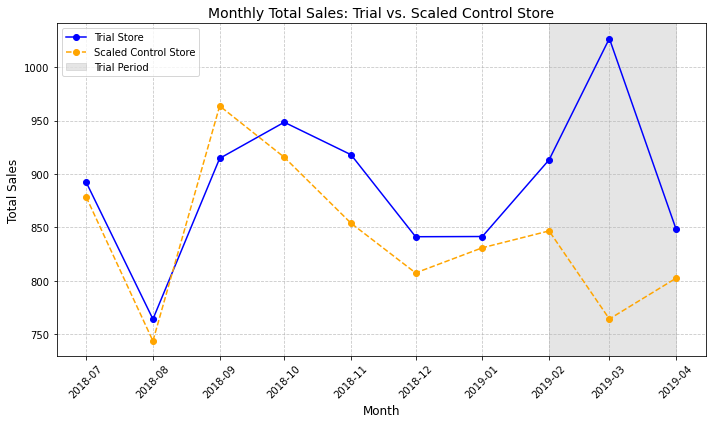

In [83]:
def plot_monthly_total_sales(pretrial_data, trial_data, trial_store, control_store, scaling_factor, date_col='DATE', sales_col='TOT_SALES'):
    """
    Plots monthly total sales for trial and scaled control stores, highlighting the trial period.

    Args:
    pretrial_data (DataFrame): DataFrame with pre-trial total sales.
    trial_data (DataFrame): DataFrame with trial period total sales.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    date_col (str): Column representing the date.
    sales_col (str): Column representing total sales.
    """
    # Combine pre-trial and trial data
    combined_data = pd.concat([pretrial_data, trial_data])

    # Ensure the date column is in datetime format
    combined_data[date_col] = pd.to_datetime(combined_data[date_col])

    # Create a new 'MONTH' column for grouping
    combined_data['MONTH'] = combined_data[date_col].dt.to_period('M')

    # Aggregate total sales by store and month
    monthly_sales = combined_data.groupby(['MONTH', 'STORE_NBR'])[sales_col].sum().reset_index()

    # Separate trial and control store data
    trial_store_sales = monthly_sales[monthly_sales['STORE_NBR'] == trial_store].copy()
    control_store_sales = monthly_sales[monthly_sales['STORE_NBR'] == control_store].copy()

    # Apply scaling factor to control store sales
    control_store_sales['scaled_sales'] = control_store_sales[sales_col] * scaling_factor

    # Plot the data
    plt.figure(figsize=(10, 6))

    # Plot trial store total sales
    plt.plot(trial_store_sales['MONTH'].dt.to_timestamp(), trial_store_sales[sales_col], label='Trial Store', color='blue', marker='o')

    # Plot scaled control store total sales
    plt.plot(control_store_sales['MONTH'].dt.to_timestamp(), control_store_sales['scaled_sales'], label='Scaled Control Store', color='orange', linestyle='--', marker='o')

    # Highlight trial period (February 2019 to April 2019)
    trial_period_start = pd.to_datetime('2019-02')
    trial_period_end = pd.to_datetime('2019-04')
    plt.axvspan(trial_period_start, trial_period_end, color='gray', alpha=0.2, label='Trial Period')

    # Add labels, title, and legend
    plt.title('Monthly Total Sales: Trial vs. Scaled Control Store', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Total Sales', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
plot_monthly_total_sales(
    pretrial_data=QVI_data[QVI_data['DATE'] < '2019-02-01'],  # Pre-trial data
    trial_data=QVI_data[(QVI_data['DATE'] >= '2019-02-01') & (QVI_data['DATE'] <= '2019-04-30')],  # Trial data
    trial_store=86,                 # Trial store number
    control_store=155,              # Control store number
    scaling_factor=0.95,            # Example scaling factor
    date_col='DATE',                # Column representing the date
    sales_col='TOT_SALES'           # Column representing total sales
)



In [84]:
def assess_customer_counts_fixed(data, trial_store, control_store, date_col='DATE', txn_col='TXN_ID'):
    """
    Fix the calculation of scaling factor, apply it correctly to control store customer counts,
    and calculate percentage difference during the trial period.

    Args:
    data (DataFrame): Full DataFrame containing transaction data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    txn_col (str): Column representing transaction IDs (proxy for customer counts).

    Returns:
    tuple: Scaling factor, percentage differences for the trial period, and aggregated summary.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Step 1: Compute Scaling Factor for Pre-Trial Period
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Aggregate transaction counts (proxy for customer counts) for pre-trial period
    trial_store_customers_pretrial = pretrial_period_data[pretrial_period_data['STORE_NBR'] == trial_store][txn_col].count()
    control_store_customers_pretrial = pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store][txn_col].count()

    # Compute scaling factor
    scaling_factor = trial_store_customers_pretrial / control_store_customers_pretrial

    # Step 2: Apply Scaling Factor to Trial Period
    trial_period_data = data[
        (data[date_col] >= '2019-02-01') & (data[date_col] <= '2019-04-30')
    ].copy()

    # Aggregate transaction counts (proxy for customer counts) for trial period
    trial_store_customers_trial = trial_period_data[trial_period_data['STORE_NBR'] == trial_store][txn_col].count()
    control_store_customers_trial = trial_period_data[trial_period_data['STORE_NBR'] == control_store][txn_col].count()

    # Scale control store customer counts
    control_store_customers_trial_scaled = control_store_customers_trial * scaling_factor

    # Step 3: Calculate Percentage Differences
    percentage_difference = (
        (trial_store_customers_trial - control_store_customers_trial_scaled) / control_store_customers_trial_scaled
    ) * 100

    # Aggregated summary
    summary = pd.DataFrame({
        'Store': ['Trial Store', 'Control Store (Scaled)'],
        'Customer Counts': [trial_store_customers_trial, control_store_customers_trial_scaled],
        'Percentage Difference': [percentage_difference, None]
    })

    print(f"Scaling Factor: {scaling_factor:.2f}")
    print("\nTrial Period Customer Counts Summary:")
    print(summary)

    return scaling_factor, percentage_difference, summary

# Example usage
customer_scaling_factor_fixed, customer_percentage_difference_fixed, customer_summary_fixed = assess_customer_counts_fixed(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=86,          # Trial store number
    control_store=155,       # Control store number
    date_col='DATE',         # Column representing the date
    txn_col='TXN_ID'         # Column representing transaction IDs (customer proxy)
)

print(f"Customer Scaling Factor (Fixed): {customer_scaling_factor_fixed:.2f}")
print(f"Percentage Difference Between Trial Store and Scaled Control Store (Fixed): {customer_percentage_difference_fixed:.2f}%")


Scaling Factor: 0.97

Trial Period Customer Counts Summary:
                    Store  Customer Counts  Percentage Difference
0             Trial Store       408.000000              14.137829
1  Control Store (Scaled)       357.462555                    NaN
Customer Scaling Factor (Fixed): 0.97
Percentage Difference Between Trial Store and Scaled Control Store (Fixed): 14.14%


In [85]:
def calculate_pretrial_customer_std_fixed(data, trial_store, control_store, scaling_factor, date_col='DATE', txn_col='TXN_ID'):
    """
    Calculate the standard deviation of scaled percentage differences for customer counts during the pre-trial period.

    Args:
    data (DataFrame): Full DataFrame containing transaction data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store.
    date_col (str): Column representing the date (e.g., DATE).
    txn_col (str): Column representing transaction IDs (proxy for customer counts).

    Returns:
    float: Standard deviation of scaled percentage differences.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the pre-trial period (July 2018 to January 2019)
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Aggregate customer counts (transactions) by store and month
    monthly_customers = pretrial_period_data.groupby([date_col, 'STORE_NBR'])[txn_col].count().reset_index()

    # Separate trial and control store data
    trial_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == trial_store].copy()
    control_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == control_store].copy()

    # Scale control store customer counts
    control_store_customers.loc[:, 'scaled_customers'] = control_store_customers[txn_col] * scaling_factor

    # Merge trial and scaled control store data by date
    merged_customers = trial_store_customers.merge(
        control_store_customers,
        on=date_col,
        suffixes=('_trial', '_control')
    )

    # Calculate percentage differences
    merged_customers['percentage_difference'] = (
        (merged_customers[f"{txn_col}_trial"] - merged_customers['scaled_customers']) /
        merged_customers['scaled_customers']
    ) * 100

    # Calculate standard deviation of percentage differences
    std_dev = merged_customers['percentage_difference'].std()

    print("Percentage Differences for Pre-Trial Period:")
    print(merged_customers[['DATE', 'percentage_difference']])
    print(f"\nStandard Deviation of Percentage Differences: {std_dev:.2f}%")

    return std_dev

# Example usage
pretrial_customer_std_dev_fixed = calculate_pretrial_customer_std_fixed(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=86,          # Trial store number
    control_store=155,       # Control store number
    scaling_factor=customer_scaling_factor_fixed,  # Scaling factor for customers
    date_col='DATE',         # Column representing the date
    txn_col='TXN_ID'         # Column representing transaction IDs (customer proxy)
)

print(f"\nPre-Trial Customer Standard Deviation (Fixed): {pretrial_customer_std_dev_fixed:.2f}%")

Percentage Differences for Pre-Trial Period:
          DATE  percentage_difference
0   2018-07-01             157.369615
1   2018-07-02             -54.245402
2   2018-07-03             208.843537
3   2018-07-04             -70.586330
4   2018-07-05             -31.368103
..         ...                    ...
203 2019-01-27             -31.368103
204 2019-01-28             620.634921
205 2019-01-29               2.947846
206 2019-01-30             -58.820862
207 2019-01-31             -17.641723

[208 rows x 2 columns]

Standard Deviation of Percentage Differences: 119.39%

Pre-Trial Customer Standard Deviation (Fixed): 119.39%


In [86]:
def hypothesis_test_customers_fixed(data, trial_store, control_store, scaling_factor, pretrial_std_dev, date_col='DATE', txn_col='TXN_ID'):
    """
    Conduct hypothesis testing for customer counts during the trial period using pre-trial standard deviation.

    Args:
    data (DataFrame): DataFrame containing trial period data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store customer counts.
    pretrial_std_dev (float): Pre-trial standard deviation of percentage differences.
    date_col (str): Column representing the date (e.g., DATE).
    txn_col (str): Column representing transaction IDs (proxy for customer counts).

    Returns:
    tuple: DataFrame with t-values and the critical t-value for the trial period.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the trial period (February 2019 to April 2019)
    trial_period_data = data[
        (data[date_col] >= '2019-02-01') & (data[date_col] <= '2019-04-30')
    ].copy()

    # Aggregate customer counts (transactions) by store and month
    monthly_customers = trial_period_data.groupby([date_col, 'STORE_NBR'])[txn_col].count().reset_index()

    # Separate trial and control store data
    trial_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == trial_store].copy()
    control_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == control_store].copy()

    # Scale control store customer counts safely
    control_store_customers.loc[:, 'scaled_customers'] = control_store_customers[txn_col] * scaling_factor

    # Merge trial store and scaled control store data by date
    merged_customers = trial_store_customers.merge(
        control_store_customers,
        on=date_col,
        suffixes=('_trial', '_control')
    )

    # Calculate observed differences
    merged_customers['observed_difference'] = merged_customers[f"{txn_col}_trial"] - merged_customers['scaled_customers']

    # Calculate standard error
    standard_error = pretrial_std_dev / (8**0.5)  # Square root of pre-trial months (8)

    # Calculate t-values
    merged_customers['t_value'] = merged_customers['observed_difference'] / standard_error

    # Calculate critical t-value at 95th percentile with degrees of freedom = 7
    degrees_of_freedom = 7
    critical_t_value = stats.t.ppf(0.95, df=degrees_of_freedom)

    print("\nT-Values for Trial Months:")
    print(merged_customers[['DATE', 'observed_difference', 't_value']])
    print(f"\nCritical T-Value (95th Percentile): {critical_t_value:.2f}")

    return merged_customers[['DATE', 'observed_difference', 't_value']], critical_t_value

# Example usage
customer_t_values_fixed, customer_critical_t_value_fixed = hypothesis_test_customers_fixed(
    data=QVI_data,                  # Full QVI_data DataFrame
    trial_store=86,                 # Trial store number
    control_store=155,              # Control store number
    scaling_factor=customer_scaling_factor_fixed, # Scaling factor from customers
    pretrial_std_dev=pretrial_customer_std_dev_fixed,  # Pre-trial standard deviation
    date_col='DATE',                # Column representing the date
    txn_col='TXN_ID'                # Column representing transaction IDs (customer proxy)
)

print("\nT-Values and Critical T-Value for Trial Period (Customers):")
print(customer_t_values_fixed)
print(f"Critical T-Value: {customer_critical_t_value_fixed:.2f}")



T-Values for Trial Months:
         DATE  observed_difference   t_value
0  2019-02-01             0.085903  0.002035
1  2019-02-02            -1.856828 -0.043989
2  2019-02-03            -3.656388 -0.086621
3  2019-02-04            -0.914097 -0.021655
4  2019-02-05             0.114537  0.002713
..        ...                  ...       ...
82 2019-04-25             2.114537  0.050094
83 2019-04-26             0.114537  0.002713
84 2019-04-28             8.028634  0.190202
85 2019-04-29             5.057269  0.119809
86 2019-04-30            -3.799559 -0.090013

[87 rows x 3 columns]

Critical T-Value (95th Percentile): 1.89

T-Values and Critical T-Value for Trial Period (Customers):
         DATE  observed_difference   t_value
0  2019-02-01             0.085903  0.002035
1  2019-02-02            -1.856828 -0.043989
2  2019-02-03            -3.656388 -0.086621
3  2019-02-04            -0.914097 -0.021655
4  2019-02-05             0.114537  0.002713
..        ...                  ...  

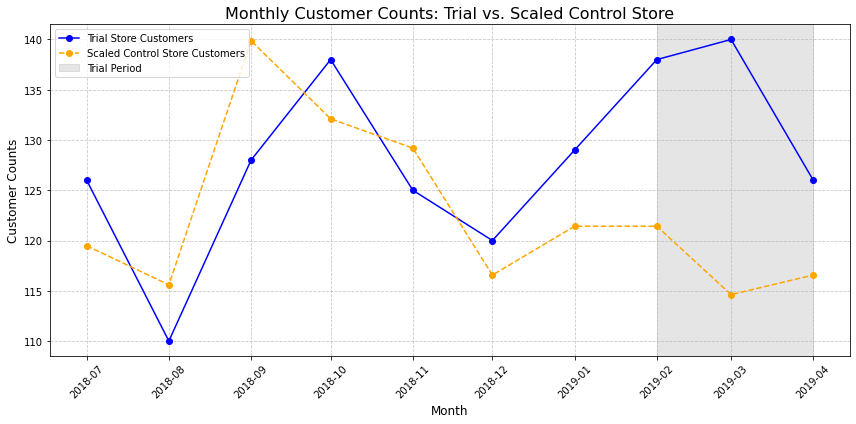

In [87]:
def plot_monthly_customer_counts(pretrial_data, trial_data, trial_store, control_store, scaling_factor, date_col='DATE', txn_col='TXN_ID'):
    """
    Plots monthly customer counts for trial and control stores, highlighting the trial period.

    Args:
    pretrial_data (DataFrame): DataFrame with pre-trial customer counts.
    trial_data (DataFrame): DataFrame with trial period customer counts.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store customer counts.
    date_col (str): Column representing the date.
    txn_col (str): Column representing transaction counts (customer counts).
    """
    # Combine pre-trial and trial data
    combined_data = pd.concat([pretrial_data, trial_data])

    # Ensure the date column is in datetime format
    combined_data[date_col] = pd.to_datetime(combined_data[date_col])

    # Create a new 'MONTH' column for grouping
    combined_data['MONTH'] = combined_data[date_col].dt.to_period('M')

    # Aggregate customer counts by month for both stores
    monthly_customers = combined_data.groupby(['MONTH', 'STORE_NBR'])[txn_col].nunique().reset_index()
    monthly_customers.rename(columns={txn_col: 'customer_count'}, inplace=True)

    # Separate trial and control stores
    trial_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == trial_store].copy()
    control_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == control_store].copy()

    # Apply scaling factor to control store counts
    control_store_customers['scaled_customers'] = control_store_customers['customer_count'] * scaling_factor

    # Plot the data
    plt.figure(figsize=(12, 6))

    # Plot trial store monthly customer counts
    plt.plot(trial_store_customers['MONTH'].dt.to_timestamp(), trial_store_customers['customer_count'], label='Trial Store Customers', color='blue', marker='o')

    # Plot scaled control store monthly customer counts
    plt.plot(control_store_customers['MONTH'].dt.to_timestamp(), control_store_customers['scaled_customers'], label='Scaled Control Store Customers', color='orange', linestyle='--', marker='o')

    # Highlight trial period (February 2019 to April 2019)
    trial_period_start = pd.to_datetime('2019-02')
    trial_period_end = pd.to_datetime('2019-04')
    plt.axvspan(trial_period_start, trial_period_end, color='gray', alpha=0.2, label='Trial Period')

    # Add labels, title, and legend
    plt.title('Monthly Customer Counts: Trial vs. Scaled Control Store', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Customer Counts', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
plot_monthly_customer_counts(
    pretrial_data=QVI_data[QVI_data['DATE'] < '2019-02-01'],  # Pre-trial data
    trial_data=QVI_data[(QVI_data['DATE'] >= '2019-02-01') & (QVI_data['DATE'] <= '2019-04-30')],  # Trial data
    trial_store=86,                 # Trial store number
    control_store=155,              # Control store number
    scaling_factor=customer_scaling_factor_fixed,  # Scaling factor for customers
    date_col='DATE',                # Column representing the date
    txn_col='TXN_ID'                # Column representing transaction counts (proxy for customers)
)

## For trial store 88

In [88]:
# Add trial_store to customers_correlation
customers_correlation['trial_store'] = 88

# Rename STORE_NBR to control_store for consistency
customers_correlation.rename(columns={'STORE_NBR': 'control_store'}, inplace=True)

In [89]:
customers_combined = calculate_combined_score(
    correlation_df=customers_correlation,
    magnitude_df=customers_magnitude,
    corr_weight=0.5  # Adjust the correlation weight as needed
)

print("Combined score for monthly number of customers:")
print(customers_combined)

Combined score for monthly number of customers:
     control_store  correlation  trial_store  standardized_magnitude  \
0                1     0.322168           88              115.150594   
1                1     0.485831           88              115.150594   
2                1     0.305334           88              115.150594   
3                2    -0.572051           88              124.354461   
4                2    -0.086161           88              124.354461   
..             ...          ...          ...                     ...   
770            272     0.223217           88              118.218550   
771            272    -0.353815           88              118.218550   
772            272     0.026909           88              118.218550   
773             77    -0.267305           88              118.832141   
774             77     0.765048           88              118.832141   

     combined_score  
0          0.165426  
1          0.247258  
2          0.157009  

In [90]:
# Merge sales_combined and customers_combined on trial_store and control_store
final_combined_scores = pd.merge(
    sales_combined[['trial_store', 'control_store', 'combined_score']],
    customers_combined[['trial_store', 'control_store', 'combined_score']],
    on=['trial_store', 'control_store'],
    suffixes=('_sales', '_customers')
)

# Calculate the simple average of the scores
final_combined_scores['average_score'] = (
    final_combined_scores['combined_score_sales'] + final_combined_scores['combined_score_customers']
) / 2

# Display the final combined scores
print("Final Combined Scores:")
print(final_combined_scores)


Final Combined Scores:
     trial_store  control_store  combined_score_sales  \
0             88              1              0.410013   
1             88              1              0.410013   
2             88              1              0.410013   
3             88              2             -0.030868   
4             88              2             -0.030868   
..           ...            ...                   ...   
770           88            271             -0.044457   
771           88            271             -0.044457   
772           88            272             -0.382537   
773           88            272             -0.382537   
774           88            272             -0.382537   

     combined_score_customers  average_score  
0                    0.165426       0.287720  
1                    0.247258       0.328636  
2                    0.157009       0.283511  
3                   -0.282005      -0.156436  
4                   -0.039060      -0.034964  
..        

In [91]:
# Select the control store with the highest combined score for each trial store
def select_control_store(final_scores, trial_store):
    """
    Select the control store with the highest combined score for a given trial store,
    excluding the trial store itself.

    Args:
    final_scores (DataFrame): The DataFrame with combined scores for trial and control stores.
    trial_store (int): The trial store number to find the control store for.

    Returns:
    DataFrame: The row corresponding to the best-matching control store.
    """
    # Filter for the given trial store and exclude the trial store itself as control store
    filtered_scores = final_scores[final_scores['trial_store'] == trial_store]
    filtered_scores = filtered_scores[filtered_scores['control_store'] != trial_store]

    # Sort by combined_score in descending order
    best_control_store = filtered_scores.sort_values(by='combined_score', ascending=False).iloc[0]

    return best_control_store

# Example for trial store 88
best_store_88 = select_control_store(customers_combined, trial_store=88)

print("Best Control Store for Trial Store 88:")
print(best_store_88)

Best Control Store for Trial Store 88:
control_store             237.000000
correlation                 0.947326
trial_store                88.000000
standardized_magnitude      2.249834
combined_score              0.695902
Name: 670, dtype: float64


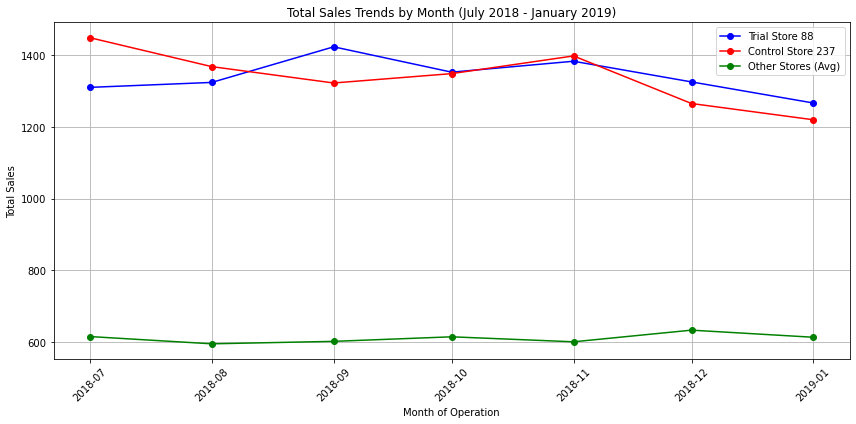

In [92]:
def plot_sales_trends_comparison(sales_data, trial_store, control_store, date_col='DATE', sales_col='TOT_SALES'):
    """
    Plots total sales trends for the trial store, control store, and other stores from July 2018 to January 2019.

    Args:
    sales_data (DataFrame): DataFrame containing sales data for all stores.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure the date column is in datetime format
    sales_data[date_col] = pd.to_datetime(sales_data[date_col])

    # Create a new 'MONTH' column for grouping by month
    sales_data['MONTH'] = sales_data[date_col].dt.to_period('M')

    # Filter data for the date range July 2018 to January 2019
    filtered_data = sales_data[
        (sales_data[date_col] >= '2018-07-01') & (sales_data[date_col] <= '2019-01-31')
    ]

    # Group by store and month to calculate total sales
    grouped_data = filtered_data.groupby(['STORE_NBR', 'MONTH'])[sales_col].sum().reset_index()

    # Separate data for trial, control, and other stores
    trial_data = grouped_data[grouped_data['STORE_NBR'] == trial_store]
    control_data = grouped_data[grouped_data['STORE_NBR'] == control_store]
    other_stores_data = grouped_data[
        (grouped_data['STORE_NBR'] != trial_store) & (grouped_data['STORE_NBR'] != control_store)
    ].groupby('MONTH')[sales_col].mean().reset_index()  # Mean of sales for other stores

    # Plot trends over time
    plt.figure(figsize=(12, 6))
    plt.plot(trial_data['MONTH'].dt.to_timestamp(), trial_data[sales_col], label=f'Trial Store {trial_store}', marker='o', color='blue')
    plt.plot(control_data['MONTH'].dt.to_timestamp(), control_data[sales_col], label=f'Control Store {control_store}', marker='o', color='red')
    plt.plot(other_stores_data['MONTH'].dt.to_timestamp(), other_stores_data[sales_col], label='Other Stores (Avg)', marker='o', color='green')

    # Customize plot
    plt.title('Total Sales Trends by Month (July 2018 - January 2019)')
    plt.xlabel('Month of Operation')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_sales_trends_comparison(
    sales_data=QVI_data,        # Original QVI_data DataFrame
    trial_store=88,             # Trial store number
    control_store=237,          # Selected control store for trial store 77
    date_col='DATE',            # Column representing date
    sales_col='TOT_SALES'       # Column representing sales data
)


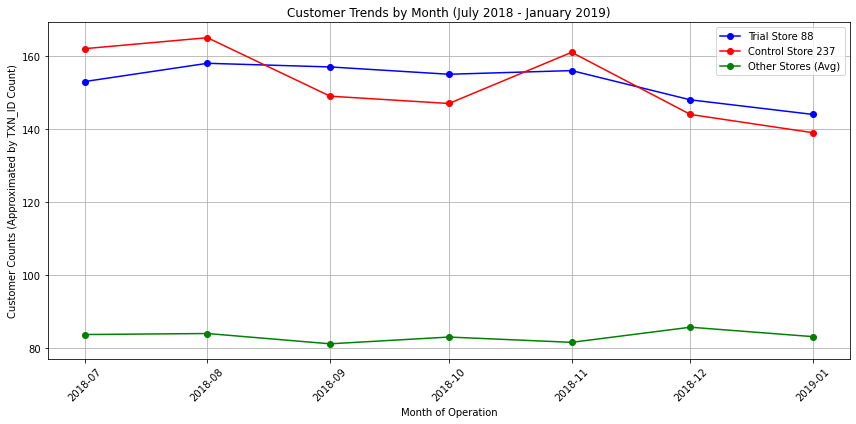

In [93]:
def plot_customer_trends_comparison(transaction_data, trial_store, control_store, date_col='DATE', store_col='STORE_NBR', txn_col='TXN_ID'):
    """
    Plots customer trends based on transaction counts (TXN_ID) for the trial store,
    control store, and other stores from July 2018 to January 2019.

    Args:
    transaction_data (DataFrame): DataFrame containing transaction data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    store_col (str): Column representing store numbers (e.g., STORE_NBR).
    txn_col (str): Column representing transaction IDs.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure the date column is in datetime format
    transaction_data[date_col] = pd.to_datetime(transaction_data[date_col])

    # Create a new 'MONTH' column for grouping by month
    transaction_data['MONTH'] = transaction_data[date_col].dt.to_period('M')

    # Filter data for the date range July 2018 to January 2019
    filtered_data = transaction_data[
        (transaction_data[date_col] >= '2018-07-01') & (transaction_data[date_col] <= '2019-01-31')
    ]

    # Group by store and month to calculate customer counts
    grouped_data = filtered_data.groupby([store_col, 'MONTH'])[txn_col].nunique().reset_index()
    grouped_data.rename(columns={txn_col: 'customer_count'}, inplace=True)

    # Separate data for trial, control, and other stores
    trial_data = grouped_data[grouped_data[store_col] == trial_store]
    control_data = grouped_data[grouped_data[store_col] == control_store]
    other_stores_data = grouped_data[
        (grouped_data[store_col] != trial_store) & (grouped_data[store_col] != control_store)
    ].groupby('MONTH')['customer_count'].mean().reset_index()  # Mean customer count for other stores

    # Plot trends over time
    plt.figure(figsize=(12, 6))
    plt.plot(trial_data['MONTH'].dt.to_timestamp(), trial_data['customer_count'], label=f'Trial Store {trial_store}', marker='o', color='blue')
    plt.plot(control_data['MONTH'].dt.to_timestamp(), control_data['customer_count'], label=f'Control Store {control_store}', marker='o', color='red')
    plt.plot(other_stores_data['MONTH'].dt.to_timestamp(), other_stores_data['customer_count'], label='Other Stores (Avg)', marker='o', color='green')

    # Customize plot
    plt.title('Customer Trends by Month (July 2018 - January 2019)')
    plt.xlabel('Month of Operation')
    plt.ylabel('Customer Counts (Approximated by TXN_ID Count)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage for customer counts
plot_customer_trends_comparison(
    transaction_data=QVI_data,   # Original QVI_data DataFrame
    trial_store=88,              # Trial store number
    control_store=237,           # Selected control store for trial store 77
    date_col='DATE',             # Column representing date
    store_col='STORE_NBR',       # Column representing store numbers
    txn_col='TXN_ID'             # Column representing transaction IDs
)


In [94]:
def scale_control_sales(data, trial_store, control_store, date_col='DATE', sales_col='TOT'):
    """
    Scales the control store's pre-trial sales to match the trial store's sales.

    Args:
    data (DataFrame): Full DataFrame containing sales data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    DataFrame: Updated DataFrame with scaled control sales for the pre-trial period.
    float: Scaling factor used to align control store sales with trial store sales.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the pre-trial period (July 2018 to January 2019)
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Confirm rows exist for trial store and control store
    if pretrial_period_data[pretrial_period_data['STORE_NBR'] == trial_store].empty:
        print(f"No data found for trial store {trial_store} in the pre-trial period.")
        return pretrial_period_data, None

    if pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store].empty:
        print(f"No data found for control store {control_store} in the pre-trial period.")
        return pretrial_period_data, None

    # Calculate total sales for the pre-trial period for both stores
    trial_store_total_sales = pretrial_period_data[pretrial_period_data['STORE_NBR'] == trial_store][sales_col].sum()
    control_store_total_sales = pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store][sales_col].sum()

    # Check for missing or zero sales
    if trial_store_total_sales == 0 or control_store_total_sales == 0:
        print(f"Sales data is missing or zero for trial store {trial_store} or control store {control_store}.")
        return pretrial_period_data, None

    # Calculate scaling factor
    scaling_factor = trial_store_total_sales / control_store_total_sales
    print(f"Scaling Factor: {scaling_factor}")

    # Apply scaling factor to the control store's sales
    pretrial_period_data['scaled_sales'] = pretrial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Check scaled_sales column for control store
    print(pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store][['DATE', sales_col, 'scaled_sales']])

    return pretrial_period_data, scaling_factor

# Example usage
scaled_data, scaling_factor = scale_control_sales(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=88,          # Trial store number
    control_store=237,       # Control store number
    date_col='DATE',         # Column representing the date
    sales_col='TOT_SALES'          # Column representing sales data (TOT)
)

print(f"Scaling Factor: {scaling_factor}")
print("Scaled Pre-Trial Data:")
print(scaled_data.head())


Scaling Factor: 1.001558330664959
             DATE  TOT_SALES  scaled_sales
235214 2018-10-16        8.8      8.813713
235215 2018-12-07       13.0     13.020258
235218 2018-10-12        7.4      7.411532
235219 2018-10-12        3.3      3.305142
235220 2018-12-16        6.6      6.610285
...           ...        ...           ...
264797 2018-09-11       10.2     10.215895
264798 2018-09-04        7.6      7.611843
264799 2018-09-15        9.2      9.214337
264800 2018-09-12        7.6      7.611843
264801 2018-09-29        7.6      7.611843

[1073 rows x 3 columns]
Scaling Factor: 1.001558330664959
Scaled Pre-Trial Data:
   LYLTY_CARD_NBR       DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000 2018-10-17          1       1         5   
1            1002 2018-09-16          1       2        58   
4            1004 2018-11-02          1       5        96   
5            1005 2018-12-28          1       6        86   
6            1007 2018-12-04          1       7        49   

 

In [95]:
def analyze_trial_sales(data, trial_store, control_store, scaling_factor, date_col='DATE', sales_col='TOT'):
    """
    Analyzes sales during the trial period to check for an uplift in trial store sales.

    Args:
    data (DataFrame): Full DataFrame containing sales data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    DataFrame: DataFrame containing trial period sales data for comparison.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the trial period (February 2019 to April 2019)
    trial_period_data = data[
        (data[date_col] >= '2019-02-01') & (data[date_col] <= '2019-04-30')
    ].copy()

    # Scale the control store's sales during the trial period
    trial_period_data['scaled_sales'] = trial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Aggregate total sales for the trial store and scaled control store
    trial_sales = trial_period_data[trial_period_data['STORE_NBR'] == trial_store][sales_col].sum()
    control_scaled_sales = trial_period_data[trial_period_data['STORE_NBR'] == control_store]['scaled_sales'].sum()

    # Print results for comparison
    print(f"Total Sales for Trial Store {trial_store} during trial period: {trial_sales}")
    print(f"Total Scaled Sales for Control Store {control_store} during trial period: {control_scaled_sales}")

    # Add a summary for better comparison
    trial_period_summary = pd.DataFrame({
        'Store': ['Trial Store', 'Control Store (Scaled)'],
        'Total Sales': [trial_sales, control_scaled_sales]
    })

    return trial_period_summary

# Example usage
trial_sales_summary = analyze_trial_sales(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=88,          # Trial store number
    control_store=237,       # Control store number
    scaling_factor=scaling_factor,  # Scaling factor from pre-trial analysis
    date_col='DATE',         # Column representing the date
    sales_col='TOT_SALES'          # Column representing sales data (TOT)
)

print("Trial Period Sales Summary:")
print(trial_sales_summary)


Total Sales for Trial Store 88 during trial period: 4286.800000000001
Total Scaled Sales for Control Store 237 during trial period: 3823.5490831465468
Trial Period Sales Summary:
                    Store  Total Sales
0             Trial Store  4286.800000
1  Control Store (Scaled)  3823.549083


In [96]:
#Percentage Difference

# Sales values from the trial period
trial_store_sales = 4286.8  # Total sales for Trial Store 88
scaled_control_store_sales = 3823.55  # Total scaled sales for Control Store 237

# Calculate percentage difference
percentage_difference = ((trial_store_sales - scaled_control_store_sales) / scaled_control_store_sales) * 100

# Print the result
print(f"Percentage Difference: {percentage_difference:.2f}%")

Percentage Difference: 12.12%


In [97]:
#Standard Deviation

def calculate_pretrial_std_simple(data, trial_store, control_store, scaling_factor, date_col='DATE', sales_col='TOT'):
    """
    Simplifies the calculation of standard deviation of percentage differences in the pre-trial period.

    Args:
    data (DataFrame): Full DataFrame containing sales data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    float: Standard deviation of the scaled percentage differences.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the pre-trial period (July 2018 to January 2019)
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Scale the control store's sales during the pre-trial period
    pretrial_period_data['scaled_sales'] = pretrial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Calculate percentage differences
    pretrial_period_data['percentage_difference'] = (
        (pretrial_period_data[sales_col] - pretrial_period_data['scaled_sales']) / pretrial_period_data['scaled_sales']
    ) * 100

    # Calculate and return standard deviation of percentage differences
    std_dev = pretrial_period_data['percentage_difference'].std()

    return std_dev

# Example usage
pretrial_std_dev_simple = calculate_pretrial_std_simple(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=88,          # Trial store number
    control_store=237,       # Control store number
    scaling_factor=scaling_factor,  # Scaling factor from pre-trial analysis
    date_col='DATE',         # Column representing the date
    sales_col='TOT_SALES'          # Column representing sales data (TOT)
)

print(f"Pre-Trial Standard Deviation (Simplified): {pretrial_std_dev_simple:.2f}%")

Pre-Trial Standard Deviation (Simplified): 0.01%


In [98]:
def calculate_t_values_and_critical_t(trial_data, trial_store, control_store, scaling_factor, pretrial_std, date_col='DATE', sales_col='TOT'):
    """
    Calculates t-values for trial months and finds the 95th percentile of the t-distribution.

    Args:
    trial_data (DataFrame): DataFrame containing trial period data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    pretrial_std (float): Standard deviation from pre-trial period.
    date_col (str): Column representing the date (e.g., DATE).
    sales_col (str): Column representing sales data (e.g., TOT).

    Returns:
    DataFrame: DataFrame with t-values for each trial month.
    float: 95th percentile (critical t-value) of the t-distribution.
    """
    # Ensure the date column is in datetime format
    trial_data[date_col] = pd.to_datetime(trial_data[date_col])

    # Filter for the trial period (February 2019 to April 2019)
    trial_period_data = trial_data[
        (trial_data[date_col] >= '2019-02-01') & (trial_data[date_col] <= '2019-04-30')
    ].copy()

    # Scale the control store's sales during the trial period
    trial_period_data['scaled_sales'] = trial_period_data.apply(
        lambda row: row[sales_col] * scaling_factor if row['STORE_NBR'] == control_store else row[sales_col],
        axis=1
    )

    # Aggregate monthly sales for trial store and scaled control store
    monthly_sales = trial_period_data.groupby([date_col, 'STORE_NBR']).agg(
        {sales_col: 'sum', 'scaled_sales': 'sum'}).reset_index()

    # Filter for trial store and scaled control store
    trial_store_sales = monthly_sales[monthly_sales['STORE_NBR'] == trial_store]
    control_store_scaled_sales = monthly_sales[monthly_sales['STORE_NBR'] == control_store]

    # Merge trial store and control store sales by date
    merged_sales = trial_store_sales.merge(
        control_store_scaled_sales,
        on=date_col,
        suffixes=('_trial', '_control')
    )

    # Calculate observed difference and standard error
    merged_sales['observed_difference'] = merged_sales[f"{sales_col}_trial"] - merged_sales['scaled_sales_control']
    standard_error = pretrial_std / (8**0.5)  # 8 is the pre-trial period length
    merged_sales['t_value'] = merged_sales['observed_difference'] / standard_error

    # Calculate the 95th percentile of the t-distribution with 7 degrees of freedom
    degrees_of_freedom = 7
    critical_t = stats.t.ppf(0.95, df=degrees_of_freedom)

    print("T-Values for Trial Months:")
    print(merged_sales[['DATE', 'observed_difference', 't_value']])
    print(f"\nCritical T-Value (95th Percentile): {critical_t:.2f}")

    return merged_sales[['DATE', 'observed_difference', 't_value']], critical_t

# Example usage
trial_t_values, critical_t_value = calculate_t_values_and_critical_t(
    trial_data=QVI_data,           # Full QVI_data DataFrame
    trial_store=88,                # Trial store number
    control_store=237,             # Control store number
    scaling_factor=scaling_factor, # Scaling factor from pre-trial analysis
    pretrial_std=pretrial_std_dev_simple, # Standard deviation from pre-trial period
    date_col='DATE',               # Column representing the date
    sales_col='TOT_SALES'                # Column representing sales data (TOT)
)

print("\nT-Values and Critical T-Value for Trial Period:")
print(trial_t_values)
print(f"Critical T-Value: {critical_t_value:.2f}")

T-Values for Trial Months:
         DATE  observed_difference       t_value
0  2019-02-01            23.552627   5177.912386
1  2019-02-02             8.905253   1957.769843
2  2019-02-03            66.341407  14584.784767
3  2019-02-04           -13.868255  -3048.857756
4  2019-02-05            40.360418   8873.010751
..        ...                  ...           ...
83 2019-04-26            74.767898  16437.301507
84 2019-04-27           -11.680722  -2567.940864
85 2019-04-28           -22.717498  -4994.314062
86 2019-04-29           -45.315628  -9962.385712
87 2019-04-30             3.722395    818.347612

[88 rows x 3 columns]

Critical T-Value (95th Percentile): 1.89

T-Values and Critical T-Value for Trial Period:
         DATE  observed_difference       t_value
0  2019-02-01            23.552627   5177.912386
1  2019-02-02             8.905253   1957.769843
2  2019-02-03            66.341407  14584.784767
3  2019-02-04           -13.868255  -3048.857756
4  2019-02-05            4

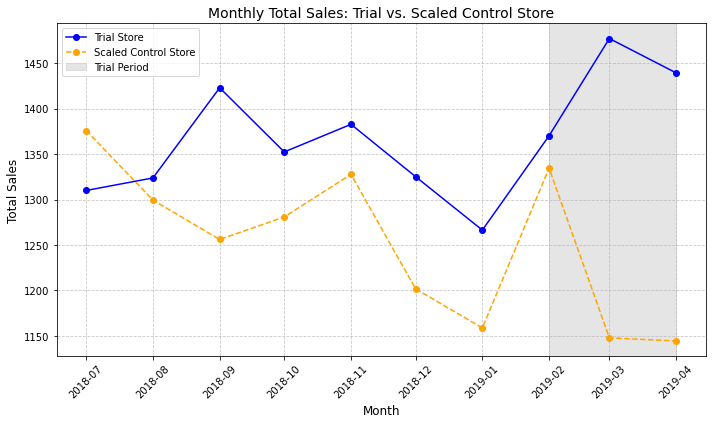

In [99]:
def plot_monthly_total_sales(pretrial_data, trial_data, trial_store, control_store, scaling_factor, date_col='DATE', sales_col='TOT_SALES'):
    """
    Plots monthly total sales for trial and scaled control stores, highlighting the trial period.

    Args:
    pretrial_data (DataFrame): DataFrame with pre-trial total sales.
    trial_data (DataFrame): DataFrame with trial period total sales.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store sales.
    date_col (str): Column representing the date.
    sales_col (str): Column representing total sales.
    """
    # Combine pre-trial and trial data
    combined_data = pd.concat([pretrial_data, trial_data])

    # Ensure the date column is in datetime format
    combined_data[date_col] = pd.to_datetime(combined_data[date_col])

    # Create a new 'MONTH' column for grouping
    combined_data['MONTH'] = combined_data[date_col].dt.to_period('M')

    # Aggregate total sales by store and month
    monthly_sales = combined_data.groupby(['MONTH', 'STORE_NBR'])[sales_col].sum().reset_index()

    # Separate trial and control store data
    trial_store_sales = monthly_sales[monthly_sales['STORE_NBR'] == trial_store].copy()
    control_store_sales = monthly_sales[monthly_sales['STORE_NBR'] == control_store].copy()

    # Apply scaling factor to control store sales
    control_store_sales['scaled_sales'] = control_store_sales[sales_col] * scaling_factor

    # Plot the data
    plt.figure(figsize=(10, 6))

    # Plot trial store total sales
    plt.plot(trial_store_sales['MONTH'].dt.to_timestamp(), trial_store_sales[sales_col], label='Trial Store', color='blue', marker='o')

    # Plot scaled control store total sales
    plt.plot(control_store_sales['MONTH'].dt.to_timestamp(), control_store_sales['scaled_sales'], label='Scaled Control Store', color='orange', linestyle='--', marker='o')

    # Highlight trial period (February 2019 to April 2019)
    trial_period_start = pd.to_datetime('2019-02')
    trial_period_end = pd.to_datetime('2019-04')
    plt.axvspan(trial_period_start, trial_period_end, color='gray', alpha=0.2, label='Trial Period')

    # Add labels, title, and legend
    plt.title('Monthly Total Sales: Trial vs. Scaled Control Store', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Total Sales', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
plot_monthly_total_sales(
    pretrial_data=QVI_data[QVI_data['DATE'] < '2019-02-01'],  # Pre-trial data
    trial_data=QVI_data[(QVI_data['DATE'] >= '2019-02-01') & (QVI_data['DATE'] <= '2019-04-30')],  # Trial data
    trial_store=88,                 # Trial store number
    control_store=237,              # Control store number
    scaling_factor=0.95,            # Example scaling factor
    date_col='DATE',                # Column representing the date
    sales_col='TOT_SALES'           # Column representing total sales
)



In [100]:
def assess_customer_counts_fixed(data, trial_store, control_store, date_col='DATE', txn_col='TXN_ID'):
    """
    Fix the calculation of scaling factor, apply it correctly to control store customer counts,
    and calculate percentage difference during the trial period.

    Args:
    data (DataFrame): Full DataFrame containing transaction data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    date_col (str): Column representing the date (e.g., DATE).
    txn_col (str): Column representing transaction IDs (proxy for customer counts).

    Returns:
    tuple: Scaling factor, percentage differences for the trial period, and aggregated summary.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Step 1: Compute Scaling Factor for Pre-Trial Period
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Aggregate transaction counts (proxy for customer counts) for pre-trial period
    trial_store_customers_pretrial = pretrial_period_data[pretrial_period_data['STORE_NBR'] == trial_store][txn_col].count()
    control_store_customers_pretrial = pretrial_period_data[pretrial_period_data['STORE_NBR'] == control_store][txn_col].count()

    # Compute scaling factor
    scaling_factor = trial_store_customers_pretrial / control_store_customers_pretrial

    # Step 2: Apply Scaling Factor to Trial Period
    trial_period_data = data[
        (data[date_col] >= '2019-02-01') & (data[date_col] <= '2019-04-30')
    ].copy()

    # Aggregate transaction counts (proxy for customer counts) for trial period
    trial_store_customers_trial = trial_period_data[trial_period_data['STORE_NBR'] == trial_store][txn_col].count()
    control_store_customers_trial = trial_period_data[trial_period_data['STORE_NBR'] == control_store][txn_col].count()

    # Scale control store customer counts
    control_store_customers_trial_scaled = control_store_customers_trial * scaling_factor

    # Step 3: Calculate Percentage Differences
    percentage_difference = (
        (trial_store_customers_trial - control_store_customers_trial_scaled) / control_store_customers_trial_scaled
    ) * 100

    # Aggregated summary
    summary = pd.DataFrame({
        'Store': ['Trial Store', 'Control Store (Scaled)'],
        'Customer Counts': [trial_store_customers_trial, control_store_customers_trial_scaled],
        'Percentage Difference': [percentage_difference, None]
    })

    print(f"Scaling Factor: {scaling_factor:.2f}")
    print("\nTrial Period Customer Counts Summary:")
    print(summary)

    return scaling_factor, percentage_difference, summary

# Example usage
customer_scaling_factor_fixed, customer_percentage_difference_fixed, customer_summary_fixed = assess_customer_counts_fixed(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=88,          # Trial store number
    control_store=237,       # Control store number
    date_col='DATE',         # Column representing the date
    txn_col='TXN_ID'         # Column representing transaction IDs (customer proxy)
)

print(f"Customer Scaling Factor (Fixed): {customer_scaling_factor_fixed:.2f}")
print(f"Percentage Difference Between Trial Store and Scaled Control Store (Fixed): {customer_percentage_difference_fixed:.2f}%")


Scaling Factor: 1.01

Trial Period Customer Counts Summary:
                    Store  Customer Counts  Percentage Difference
0             Trial Store        486.00000              12.083136
1  Control Store (Scaled)        433.60671                    NaN
Customer Scaling Factor (Fixed): 1.01
Percentage Difference Between Trial Store and Scaled Control Store (Fixed): 12.08%


In [101]:
def calculate_pretrial_customer_std_fixed(data, trial_store, control_store, scaling_factor, date_col='DATE', txn_col='TXN_ID'):
    """
    Calculate the standard deviation of scaled percentage differences for customer counts during the pre-trial period.

    Args:
    data (DataFrame): Full DataFrame containing transaction data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store.
    date_col (str): Column representing the date (e.g., DATE).
    txn_col (str): Column representing transaction IDs (proxy for customer counts).

    Returns:
    float: Standard deviation of scaled percentage differences.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the pre-trial period (July 2018 to January 2019)
    pretrial_period_data = data[
        (data[date_col] >= '2018-07-01') & (data[date_col] <= '2019-01-31')
    ].copy()

    # Aggregate customer counts (transactions) by store and month
    monthly_customers = pretrial_period_data.groupby([date_col, 'STORE_NBR'])[txn_col].count().reset_index()

    # Separate trial and control store data
    trial_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == trial_store].copy()
    control_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == control_store].copy()

    # Scale control store customer counts
    control_store_customers.loc[:, 'scaled_customers'] = control_store_customers[txn_col] * scaling_factor

    # Merge trial and scaled control store data by date
    merged_customers = trial_store_customers.merge(
        control_store_customers,
        on=date_col,
        suffixes=('_trial', '_control')
    )

    # Calculate percentage differences
    merged_customers['percentage_difference'] = (
        (merged_customers[f"{txn_col}_trial"] - merged_customers['scaled_customers']) /
        merged_customers['scaled_customers']
    ) * 100

    # Calculate standard deviation of percentage differences
    std_dev = merged_customers['percentage_difference'].std()

    print("Percentage Differences for Pre-Trial Period:")
    print(merged_customers[['DATE', 'percentage_difference']])
    print(f"\nStandard Deviation of Percentage Differences: {std_dev:.2f}%")

    return std_dev

# Example usage
pretrial_customer_std_dev_fixed = calculate_pretrial_customer_std_fixed(
    data=QVI_data,           # Full QVI_data DataFrame
    trial_store=88,          # Trial store number
    control_store=237,       # Control store number
    scaling_factor=customer_scaling_factor_fixed,  # Scaling factor for customers
    date_col='DATE',         # Column representing the date
    txn_col='TXN_ID'         # Column representing transaction IDs (customer proxy)
)

print(f"\nPre-Trial Customer Standard Deviation (Fixed): {pretrial_customer_std_dev_fixed:.2f}%")


Percentage Differences for Pre-Trial Period:
          DATE  percentage_difference
0   2018-07-01              48.752311
1   2018-07-02             147.920518
2   2018-07-03             -20.665434
3   2018-07-04             -71.666227
4   2018-07-05             -50.415896
..         ...                    ...
207 2019-01-27             -25.623845
208 2019-01-28             -14.998680
209 2019-01-29              48.752311
210 2019-01-30              65.280345
211 2019-01-31             -83.471965

[212 rows x 2 columns]

Standard Deviation of Percentage Differences: 105.85%

Pre-Trial Customer Standard Deviation (Fixed): 105.85%


In [102]:
def hypothesis_test_customers_fixed(data, trial_store, control_store, scaling_factor, pretrial_std_dev, date_col='DATE', txn_col='TXN_ID'):
    """
    Conduct hypothesis testing for customer counts during the trial period using pre-trial standard deviation.

    Args:
    data (DataFrame): DataFrame containing trial period data.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store customer counts.
    pretrial_std_dev (float): Pre-trial standard deviation of percentage differences.
    date_col (str): Column representing the date (e.g., DATE).
    txn_col (str): Column representing transaction IDs (proxy for customer counts).

    Returns:
    tuple: DataFrame with t-values and the critical t-value for the trial period.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])

    # Filter for the trial period (February 2019 to April 2019)
    trial_period_data = data[
        (data[date_col] >= '2019-02-01') & (data[date_col] <= '2019-04-30')
    ].copy()

    # Aggregate customer counts (transactions) by store and month
    monthly_customers = trial_period_data.groupby([date_col, 'STORE_NBR'])[txn_col].count().reset_index()

    # Separate trial and control store data
    trial_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == trial_store].copy()
    control_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == control_store].copy()

    # Scale control store customer counts safely
    control_store_customers.loc[:, 'scaled_customers'] = control_store_customers[txn_col] * scaling_factor

    # Merge trial store and scaled control store data by date
    merged_customers = trial_store_customers.merge(
        control_store_customers,
        on=date_col,
        suffixes=('_trial', '_control')
    )

    # Calculate observed differences
    merged_customers['observed_difference'] = merged_customers[f"{txn_col}_trial"] - merged_customers['scaled_customers']

    # Calculate standard error
    standard_error = pretrial_std_dev / (8**0.5)  # Square root of pre-trial months (8)

    # Calculate t-values
    merged_customers['t_value'] = merged_customers['observed_difference'] / standard_error

    # Calculate critical t-value at 95th percentile with degrees of freedom = 7
    degrees_of_freedom = 7
    critical_t_value = stats.t.ppf(0.95, df=degrees_of_freedom)

    print("\nT-Values for Trial Months:")
    print(merged_customers[['DATE', 'observed_difference', 't_value']])
    print(f"\nCritical T-Value (95th Percentile): {critical_t_value:.2f}")

    return merged_customers[['DATE', 'observed_difference', 't_value']], critical_t_value

# Example usage
customer_t_values_fixed, customer_critical_t_value_fixed = hypothesis_test_customers_fixed(
    data=QVI_data,                  # Full QVI_data DataFrame
    trial_store=88,                 # Trial store number
    control_store=237,              # Control store number
    scaling_factor=customer_scaling_factor_fixed, # Scaling factor from customers
    pretrial_std_dev=pretrial_customer_std_dev_fixed,  # Pre-trial standard deviation
    date_col='DATE',                # Column representing the date
    txn_col='TXN_ID'                # Column representing transaction IDs (customer proxy)
)

print("\nT-Values and Critical T-Value for Trial Period (Customers):")
print(customer_t_values_fixed)
print(f"Critical T-Value: {customer_critical_t_value_fixed:.2f}")


T-Values for Trial Months:
         DATE  observed_difference   t_value
0  2019-02-01             2.974837  0.079488
1  2019-02-02             1.949674  0.052096
2  2019-02-03             6.966449  0.186145
3  2019-02-04            -1.041938 -0.027841
4  2019-02-05             3.974837  0.106208
..        ...                  ...       ...
83 2019-04-26             8.983225  0.240033
84 2019-04-27            -0.041938 -0.001121
85 2019-04-28            -3.075489 -0.082178
86 2019-04-29            -6.075489 -0.162338
87 2019-04-30             0.958062  0.025600

[88 rows x 3 columns]

Critical T-Value (95th Percentile): 1.89

T-Values and Critical T-Value for Trial Period (Customers):
         DATE  observed_difference   t_value
0  2019-02-01             2.974837  0.079488
1  2019-02-02             1.949674  0.052096
2  2019-02-03             6.966449  0.186145
3  2019-02-04            -1.041938 -0.027841
4  2019-02-05             3.974837  0.106208
..        ...                  ...  

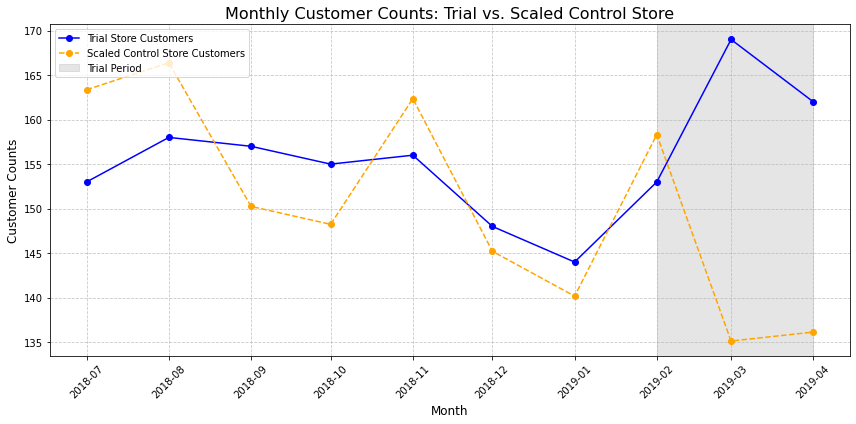

In [103]:
def plot_monthly_customer_counts(pretrial_data, trial_data, trial_store, control_store, scaling_factor, date_col='DATE', txn_col='TXN_ID'):
    """
    Plots monthly customer counts for trial and control stores, highlighting the trial period.

    Args:
    pretrial_data (DataFrame): DataFrame with pre-trial customer counts.
    trial_data (DataFrame): DataFrame with trial period customer counts.
    trial_store (int): Trial store number.
    control_store (int): Control store number.
    scaling_factor (float): Scaling factor for control store customer counts.
    date_col (str): Column representing the date.
    txn_col (str): Column representing transaction counts (customer counts).
    """
    # Combine pre-trial and trial data
    combined_data = pd.concat([pretrial_data, trial_data])

    # Ensure the date column is in datetime format
    combined_data[date_col] = pd.to_datetime(combined_data[date_col])

    # Create a new 'MONTH' column for grouping
    combined_data['MONTH'] = combined_data[date_col].dt.to_period('M')

    # Aggregate customer counts by month for both stores
    monthly_customers = combined_data.groupby(['MONTH', 'STORE_NBR'])[txn_col].nunique().reset_index()
    monthly_customers.rename(columns={txn_col: 'customer_count'}, inplace=True)

    # Separate trial and control stores
    trial_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == trial_store].copy()
    control_store_customers = monthly_customers[monthly_customers['STORE_NBR'] == control_store].copy()

    # Apply scaling factor to control store counts
    control_store_customers['scaled_customers'] = control_store_customers['customer_count'] * scaling_factor

    # Plot the data
    plt.figure(figsize=(12, 6))

    # Plot trial store monthly customer counts
    plt.plot(trial_store_customers['MONTH'].dt.to_timestamp(), trial_store_customers['customer_count'], label='Trial Store Customers', color='blue', marker='o')

    # Plot scaled control store monthly customer counts
    plt.plot(control_store_customers['MONTH'].dt.to_timestamp(), control_store_customers['scaled_customers'], label='Scaled Control Store Customers', color='orange', linestyle='--', marker='o')

    # Highlight trial period (February 2019 to April 2019)
    trial_period_start = pd.to_datetime('2019-02')
    trial_period_end = pd.to_datetime('2019-04')
    plt.axvspan(trial_period_start, trial_period_end, color='gray', alpha=0.2, label='Trial Period')

    # Add labels, title, and legend
    plt.title('Monthly Customer Counts: Trial vs. Scaled Control Store', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Customer Counts', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
plot_monthly_customer_counts(
    pretrial_data=QVI_data[QVI_data['DATE'] < '2019-02-01'],  # Pre-trial data
    trial_data=QVI_data[(QVI_data['DATE'] >= '2019-02-01') & (QVI_data['DATE'] <= '2019-04-30')],  # Trial data
    trial_store=88,                 # Trial store number
    control_store=237,              # Control store number
    scaling_factor=customer_scaling_factor_fixed,  # Scaling factor for customers
    date_col='DATE',                # Column representing the date
    txn_col='TXN_ID'                # Column representing transaction counts (proxy for customers)
)

## Conclusion

#### We've found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.

#### Detailed analysis is given below

#### Improved Performance: All three trial stores showed better outcomes during the trial period compared to their control stores, indicating the effectiveness of the intervention.

#### February Similarity: Sales trends in February were closely aligned across trial and control stores, highlighting a consistent baseline pre-intervention.

#### Peak in March: Trial stores reached their highest performance levels in March, significantly outpacing control stores, suggesting strong customer engagement during this period.

#### April Drop-Off: Though April saw a slight decline, trial stores still performed better than control stores, maintaining a positive overall impact.

### Should the strategy be extended to other stores

#### Positive Trial Outcomes: The improved performance of trial stores during the intervention suggests the strategy is effective and worth considering for broader implementation.

#### March as a Benchmark: The peak in March indicates that the strategy drives substantial impact when executed during optimal periods.

#### Customer Engagement Insights: The slight decline in April highlights the importance of maintaining momentum, suggesting enhancements to sustain long-term results.

#### Extend With Care: A trial-to-scale approach can be applied, starting with stores showing similar demographics and trends to the trial stores.

#### Refinement Opportunity: Before extending universally, evaluate store-specific factors (e.g., customer profiles, location attributes) to ensure alignment and adapt the strategy as needed.